In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 20
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_firstorder_Range_firstorder_Skewness_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm_LargeAreaLowGrayLevelEmphasis_glszm_LargeAreaHighGrayLevelEmphasis_glrlm_ShortRunEmphasis_glrlm_LongRunEmphasis_glrlm_GrayLevelNonUniformity_glrlm_GrayLevelNonUniformityNormalized_glrlm_RunLengthNonUniformity_glrlm_Run

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 648)
(4629816, 8)
validation
(621056, 648)
(621056, 8)
test
(624904, 648)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 648)]             0         


 dense (Dense)               (None, 1024)              664576    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1354632 (5.17 MB)


Trainable params: 1354632 (5.17 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 10:12 - loss: 2.2565 - STD: 0.0691 - MAE: 0.2182

  5/463 [..............................] - ETA: 6s - loss: 2.1181 - STD: 0.0557 - MAE: 0.2163   

  9/463 [..............................] - ETA: 6s - loss: 2.1015 - STD: 0.0463 - MAE: 0.2169

 13/463 [..............................] - ETA: 6s - loss: 2.0868 - STD: 0.0421 - MAE: 0.2168

 17/463 [>.............................] - ETA: 6s - loss: 2.0808 - STD: 0.0420 - MAE: 0.2167

 21/463 [>.............................] - ETA: 6s - loss: 2.0747 - STD: 0.0405 - MAE: 0.2166

 25/463 [>.............................] - ETA: 5s - loss: 2.0697 - STD: 0.0389 - MAE: 0.2166

 29/463 [>.............................] - ETA: 5s - loss: 2.0643 - STD: 0.0379 - MAE: 0.2165

 33/463 [=>............................] - ETA: 5s - loss: 2.0583 - STD: 0.0375 - MAE: 0.2164

 37/463 [=>............................] - ETA: 5s - loss: 2.0501 - STD: 0.0376 - MAE: 0.2161

 41/463 [=>............................] - ETA: 5s - loss: 2.0392 - STD: 0.0386 - MAE: 0.2157

 45/463 [=>............................] - ETA: 5s - loss: 2.0267 - STD: 0.0403 - MAE: 0.2152

 49/463 [==>...........................] - ETA: 5s - loss: 2.0126 - STD: 0.0425 - MAE: 0.2145

 53/463 [==>...........................] - ETA: 5s - loss: 1.9979 - STD: 0.0449 - MAE: 0.2138

 57/463 [==>...........................] - ETA: 5s - loss: 1.9813 - STD: 0.0474 - MAE: 0.2130

 61/463 [==>...........................] - ETA: 5s - loss: 1.9621 - STD: 0.0500 - MAE: 0.2120

 65/463 [===>..........................] - ETA: 5s - loss: 1.9420 - STD: 0.0530 - MAE: 0.2110

 69/463 [===>..........................] - ETA: 5s - loss: 1.9216 - STD: 0.0561 - MAE: 0.2099

 73/463 [===>..........................] - ETA: 5s - loss: 1.9019 - STD: 0.0592 - MAE: 0.2087

 77/463 [===>..........................] - ETA: 5s - loss: 1.8824 - STD: 0.0623 - MAE: 0.2076

 81/463 [====>.........................] - ETA: 5s - loss: 1.8633 - STD: 0.0653 - MAE: 0.2064

 85/463 [====>.........................] - ETA: 5s - loss: 1.8448 - STD: 0.0682 - MAE: 0.2053

 89/463 [====>.........................] - ETA: 5s - loss: 1.8275 - STD: 0.0711 - MAE: 0.2042

 93/463 [=====>........................] - ETA: 5s - loss: 1.8110 - STD: 0.0738 - MAE: 0.2031

 97/463 [=====>........................] - ETA: 4s - loss: 1.7945 - STD: 0.0765 - MAE: 0.2020

101/463 [=====>........................] - ETA: 4s - loss: 1.7790 - STD: 0.0791 - MAE: 0.2009

105/463 [=====>........................] - ETA: 4s - loss: 1.7639 - STD: 0.0816 - MAE: 0.1999

109/463 [======>.......................] - ETA: 4s - loss: 1.7493 - STD: 0.0840 - MAE: 0.1988

113/463 [======>.......................] - ETA: 4s - loss: 1.7355 - STD: 0.0864 - MAE: 0.1978

117/463 [======>.......................] - ETA: 4s - loss: 1.7219 - STD: 0.0886 - MAE: 0.1969

121/463 [======>.......................] - ETA: 4s - loss: 1.7089 - STD: 0.0908 - MAE: 0.1959

125/463 [=======>......................] - ETA: 4s - loss: 1.6963 - STD: 0.0929 - MAE: 0.1950

129/463 [=======>......................] - ETA: 4s - loss: 1.6845 - STD: 0.0949 - MAE: 0.1941

133/463 [=======>......................] - ETA: 4s - loss: 1.6733 - STD: 0.0969 - MAE: 0.1932

137/463 [=======>......................] - ETA: 4s - loss: 1.6624 - STD: 0.0987 - MAE: 0.1924

141/463 [========>.....................] - ETA: 4s - loss: 1.6522 - STD: 0.1005 - MAE: 0.1916

145/463 [========>.....................] - ETA: 5s - loss: 1.6421 - STD: 0.1022 - MAE: 0.1908

149/463 [========>.....................] - ETA: 5s - loss: 1.6323 - STD: 0.1039 - MAE: 0.1900

153/463 [========>.....................] - ETA: 5s - loss: 1.6229 - STD: 0.1055 - MAE: 0.1893

157/463 [=========>....................] - ETA: 5s - loss: 1.6139 - STD: 0.1070 - MAE: 0.1886

161/463 [=========>....................] - ETA: 5s - loss: 1.6055 - STD: 0.1085 - MAE: 0.1879

165/463 [=========>....................] - ETA: 5s - loss: 1.5971 - STD: 0.1099 - MAE: 0.1872

169/463 [=========>....................] - ETA: 5s - loss: 1.5890 - STD: 0.1113 - MAE: 0.1866

173/463 [==========>...................] - ETA: 5s - loss: 1.5812 - STD: 0.1126 - MAE: 0.1860

177/463 [==========>...................] - ETA: 5s - loss: 1.5737 - STD: 0.1139 - MAE: 0.1854

181/463 [==========>...................] - ETA: 4s - loss: 1.5664 - STD: 0.1151 - MAE: 0.1848

185/463 [==========>...................] - ETA: 4s - loss: 1.5595 - STD: 0.1163 - MAE: 0.1842

189/463 [===========>..................] - ETA: 4s - loss: 1.5529 - STD: 0.1175 - MAE: 0.1837

193/463 [===========>..................] - ETA: 4s - loss: 1.5465 - STD: 0.1186 - MAE: 0.1831

197/463 [===========>..................] - ETA: 4s - loss: 1.5405 - STD: 0.1197 - MAE: 0.1826

201/463 [============>.................] - ETA: 4s - loss: 1.5345 - STD: 0.1207 - MAE: 0.1821

205/463 [============>.................] - ETA: 4s - loss: 1.5285 - STD: 0.1217 - MAE: 0.1816

209/463 [============>.................] - ETA: 4s - loss: 1.5228 - STD: 0.1227 - MAE: 0.1812

213/463 [============>.................] - ETA: 4s - loss: 1.5173 - STD: 0.1237 - MAE: 0.1807

217/463 [=============>................] - ETA: 4s - loss: 1.5120 - STD: 0.1246 - MAE: 0.1803

221/463 [=============>................] - ETA: 4s - loss: 1.5068 - STD: 0.1255 - MAE: 0.1798

225/463 [=============>................] - ETA: 3s - loss: 1.5015 - STD: 0.1264 - MAE: 0.1794

229/463 [=============>................] - ETA: 3s - loss: 1.4966 - STD: 0.1272 - MAE: 0.1789

233/463 [==============>...............] - ETA: 3s - loss: 1.4916 - STD: 0.1281 - MAE: 0.1785

237/463 [==============>...............] - ETA: 3s - loss: 1.4868 - STD: 0.1289 - MAE: 0.1781

241/463 [==============>...............] - ETA: 3s - loss: 1.4821 - STD: 0.1297 - MAE: 0.1777

245/463 [==============>...............] - ETA: 3s - loss: 1.4774 - STD: 0.1304 - MAE: 0.1773

249/463 [===============>..............] - ETA: 3s - loss: 1.4731 - STD: 0.1312 - MAE: 0.1770

253/463 [===============>..............] - ETA: 3s - loss: 1.4688 - STD: 0.1319 - MAE: 0.1766

257/463 [===============>..............] - ETA: 3s - loss: 1.4647 - STD: 0.1326 - MAE: 0.1762

261/463 [===============>..............] - ETA: 3s - loss: 1.4606 - STD: 0.1334 - MAE: 0.1759

265/463 [================>.............] - ETA: 3s - loss: 1.4565 - STD: 0.1340 - MAE: 0.1755

269/463 [================>.............] - ETA: 3s - loss: 1.4527 - STD: 0.1347 - MAE: 0.1752

273/463 [================>.............] - ETA: 3s - loss: 1.4488 - STD: 0.1353 - MAE: 0.1749

277/463 [================>.............] - ETA: 3s - loss: 1.4450 - STD: 0.1360 - MAE: 0.1745

281/463 [=================>............] - ETA: 2s - loss: 1.4413 - STD: 0.1366 - MAE: 0.1742

285/463 [=================>............] - ETA: 2s - loss: 1.4378 - STD: 0.1372 - MAE: 0.1739

289/463 [=================>............] - ETA: 2s - loss: 1.4343 - STD: 0.1378 - MAE: 0.1736

293/463 [=================>............] - ETA: 2s - loss: 1.4308 - STD: 0.1384 - MAE: 0.1733

297/463 [==================>...........] - ETA: 2s - loss: 1.4274 - STD: 0.1390 - MAE: 0.1730

301/463 [==================>...........] - ETA: 2s - loss: 1.4239 - STD: 0.1396 - MAE: 0.1727

305/463 [==================>...........] - ETA: 2s - loss: 1.4206 - STD: 0.1402 - MAE: 0.1724

309/463 [===================>..........] - ETA: 2s - loss: 1.4174 - STD: 0.1407 - MAE: 0.1721

313/463 [===================>..........] - ETA: 2s - loss: 1.4141 - STD: 0.1413 - MAE: 0.1718

317/463 [===================>..........] - ETA: 2s - loss: 1.4109 - STD: 0.1418 - MAE: 0.1715

321/463 [===================>..........] - ETA: 2s - loss: 1.4080 - STD: 0.1423 - MAE: 0.1713

325/463 [====================>.........] - ETA: 2s - loss: 1.4050 - STD: 0.1428 - MAE: 0.1710

329/463 [====================>.........] - ETA: 2s - loss: 1.4023 - STD: 0.1433 - MAE: 0.1708

333/463 [====================>.........] - ETA: 2s - loss: 1.3993 - STD: 0.1438 - MAE: 0.1705

337/463 [====================>.........] - ETA: 1s - loss: 1.3966 - STD: 0.1443 - MAE: 0.1702

341/463 [=====================>........] - ETA: 1s - loss: 1.3938 - STD: 0.1448 - MAE: 0.1700

345/463 [=====================>........] - ETA: 1s - loss: 1.3911 - STD: 0.1452 - MAE: 0.1697

349/463 [=====================>........] - ETA: 1s - loss: 1.3882 - STD: 0.1457 - MAE: 0.1695

353/463 [=====================>........] - ETA: 1s - loss: 1.3856 - STD: 0.1462 - MAE: 0.1692

357/463 [======================>.......] - ETA: 1s - loss: 1.3830 - STD: 0.1466 - MAE: 0.1690

361/463 [======================>.......] - ETA: 1s - loss: 1.3803 - STD: 0.1470 - MAE: 0.1688

365/463 [======================>.......] - ETA: 1s - loss: 1.3778 - STD: 0.1475 - MAE: 0.1685

369/463 [======================>.......] - ETA: 1s - loss: 1.3753 - STD: 0.1479 - MAE: 0.1683

373/463 [=======================>......] - ETA: 1s - loss: 1.3727 - STD: 0.1483 - MAE: 0.1681

377/463 [=======================>......] - ETA: 1s - loss: 1.3701 - STD: 0.1487 - MAE: 0.1678

381/463 [=======================>......] - ETA: 1s - loss: 1.3677 - STD: 0.1492 - MAE: 0.1676

385/463 [=======================>......] - ETA: 1s - loss: 1.3654 - STD: 0.1496 - MAE: 0.1674

389/463 [========================>.....] - ETA: 1s - loss: 1.3630 - STD: 0.1499 - MAE: 0.1672

393/463 [========================>.....] - ETA: 1s - loss: 1.3606 - STD: 0.1503 - MAE: 0.1670

397/463 [========================>.....] - ETA: 1s - loss: 1.3582 - STD: 0.1507 - MAE: 0.1668

401/463 [========================>.....] - ETA: 0s - loss: 1.3560 - STD: 0.1511 - MAE: 0.1665

405/463 [=========================>....] - ETA: 0s - loss: 1.3538 - STD: 0.1515 - MAE: 0.1663

409/463 [=========================>....] - ETA: 0s - loss: 1.3514 - STD: 0.1519 - MAE: 0.1661

413/463 [=========================>....] - ETA: 0s - loss: 1.3493 - STD: 0.1522 - MAE: 0.1659

417/463 [==========================>...] - ETA: 0s - loss: 1.3471 - STD: 0.1526 - MAE: 0.1657

421/463 [==========================>...] - ETA: 0s - loss: 1.3449 - STD: 0.1529 - MAE: 0.1655

425/463 [==========================>...] - ETA: 0s - loss: 1.3428 - STD: 0.1533 - MAE: 0.1653

429/463 [==========================>...] - ETA: 0s - loss: 1.3407 - STD: 0.1536 - MAE: 0.1651

433/463 [===========================>..] - ETA: 0s - loss: 1.3387 - STD: 0.1540 - MAE: 0.1649

437/463 [===========================>..] - ETA: 0s - loss: 1.3366 - STD: 0.1543 - MAE: 0.1647

441/463 [===========================>..] - ETA: 0s - loss: 1.3347 - STD: 0.1547 - MAE: 0.1646

445/463 [===========================>..] - ETA: 0s - loss: 1.3327 - STD: 0.1550 - MAE: 0.1644

449/463 [============================>.] - ETA: 0s - loss: 1.3308 - STD: 0.1553 - MAE: 0.1642

453/463 [============================>.] - ETA: 0s - loss: 1.3289 - STD: 0.1556 - MAE: 0.1640

457/463 [============================>.] - ETA: 0s - loss: 1.3270 - STD: 0.1560 - MAE: 0.1638

461/463 [============================>.] - ETA: 0s - loss: 1.3251 - STD: 0.1563 - MAE: 0.1637

463/463 [==============================] - 10s 19ms/step - loss: 1.3242 - STD: 0.1564 - MAE: 0.1636 - val_loss: 1.2167 - val_STD: 0.1886 - val_MAE: 0.1498


Epoch 2/10000


  1/463 [..............................] - ETA: 19s - loss: 1.1039 - STD: 0.1922 - MAE: 0.1429

  5/463 [..............................] - ETA: 6s - loss: 1.1110 - STD: 0.1925 - MAE: 0.1434 

  9/463 [..............................] - ETA: 6s - loss: 1.1170 - STD: 0.1922 - MAE: 0.1438

 13/463 [..............................] - ETA: 6s - loss: 1.1181 - STD: 0.1924 - MAE: 0.1438

 17/463 [>.............................] - ETA: 6s - loss: 1.1158 - STD: 0.1924 - MAE: 0.1437

 21/463 [>.............................] - ETA: 6s - loss: 1.1129 - STD: 0.1925 - MAE: 0.1435

 25/463 [>.............................] - ETA: 6s - loss: 1.1113 - STD: 0.1925 - MAE: 0.1434

 29/463 [>.............................] - ETA: 6s - loss: 1.1098 - STD: 0.1926 - MAE: 0.1433

 33/463 [=>............................] - ETA: 6s - loss: 1.1081 - STD: 0.1928 - MAE: 0.1431

 37/463 [=>............................] - ETA: 5s - loss: 1.1067 - STD: 0.1928 - MAE: 0.1431

 41/463 [=>............................] - ETA: 5s - loss: 1.1054 - STD: 0.1929 - MAE: 0.1429

 45/463 [=>............................] - ETA: 5s - loss: 1.1042 - STD: 0.1931 - MAE: 0.1428

 49/463 [==>...........................] - ETA: 5s - loss: 1.1033 - STD: 0.1932 - MAE: 0.1427

 53/463 [==>...........................] - ETA: 5s - loss: 1.1022 - STD: 0.1932 - MAE: 0.1426

 57/463 [==>...........................] - ETA: 5s - loss: 1.1021 - STD: 0.1934 - MAE: 0.1426

 61/463 [==>...........................] - ETA: 5s - loss: 1.1018 - STD: 0.1934 - MAE: 0.1425

 65/463 [===>..........................] - ETA: 5s - loss: 1.1017 - STD: 0.1935 - MAE: 0.1425

 69/463 [===>..........................] - ETA: 5s - loss: 1.1016 - STD: 0.1935 - MAE: 0.1425

 73/463 [===>..........................] - ETA: 5s - loss: 1.1008 - STD: 0.1936 - MAE: 0.1424

 77/463 [===>..........................] - ETA: 5s - loss: 1.1001 - STD: 0.1936 - MAE: 0.1423

 81/463 [====>.........................] - ETA: 5s - loss: 1.0996 - STD: 0.1937 - MAE: 0.1423

 85/463 [====>.........................] - ETA: 5s - loss: 1.0991 - STD: 0.1938 - MAE: 0.1422

 89/463 [====>.........................] - ETA: 5s - loss: 1.0985 - STD: 0.1939 - MAE: 0.1422

 93/463 [=====>........................] - ETA: 5s - loss: 1.0978 - STD: 0.1939 - MAE: 0.1421

 97/463 [=====>........................] - ETA: 5s - loss: 1.0971 - STD: 0.1941 - MAE: 0.1420

101/463 [=====>........................] - ETA: 5s - loss: 1.0966 - STD: 0.1941 - MAE: 0.1420

105/463 [=====>........................] - ETA: 4s - loss: 1.0963 - STD: 0.1942 - MAE: 0.1419

109/463 [======>.......................] - ETA: 4s - loss: 1.0958 - STD: 0.1943 - MAE: 0.1419

113/463 [======>.......................] - ETA: 4s - loss: 1.0955 - STD: 0.1944 - MAE: 0.1418

117/463 [======>.......................] - ETA: 4s - loss: 1.0948 - STD: 0.1944 - MAE: 0.1418

121/463 [======>.......................] - ETA: 4s - loss: 1.0944 - STD: 0.1945 - MAE: 0.1417

125/463 [=======>......................] - ETA: 4s - loss: 1.0939 - STD: 0.1946 - MAE: 0.1416

129/463 [=======>......................] - ETA: 4s - loss: 1.0931 - STD: 0.1946 - MAE: 0.1416

133/463 [=======>......................] - ETA: 4s - loss: 1.0920 - STD: 0.1947 - MAE: 0.1415

137/463 [=======>......................] - ETA: 4s - loss: 1.0915 - STD: 0.1948 - MAE: 0.1414

141/463 [========>.....................] - ETA: 4s - loss: 1.0915 - STD: 0.1949 - MAE: 0.1414

145/463 [========>.....................] - ETA: 4s - loss: 1.0914 - STD: 0.1949 - MAE: 0.1413

149/463 [========>.....................] - ETA: 4s - loss: 1.0911 - STD: 0.1950 - MAE: 0.1413

153/463 [========>.....................] - ETA: 4s - loss: 1.0912 - STD: 0.1951 - MAE: 0.1413

157/463 [=========>....................] - ETA: 4s - loss: 1.0909 - STD: 0.1951 - MAE: 0.1412

161/463 [=========>....................] - ETA: 4s - loss: 1.0906 - STD: 0.1952 - MAE: 0.1412

165/463 [=========>....................] - ETA: 4s - loss: 1.0901 - STD: 0.1952 - MAE: 0.1412

169/463 [=========>....................] - ETA: 4s - loss: 1.0895 - STD: 0.1953 - MAE: 0.1411

173/463 [==========>...................] - ETA: 4s - loss: 1.0887 - STD: 0.1953 - MAE: 0.1410

177/463 [==========>...................] - ETA: 3s - loss: 1.0882 - STD: 0.1954 - MAE: 0.1410

181/463 [==========>...................] - ETA: 3s - loss: 1.0874 - STD: 0.1955 - MAE: 0.1409

185/463 [==========>...................] - ETA: 3s - loss: 1.0871 - STD: 0.1956 - MAE: 0.1409

189/463 [===========>..................] - ETA: 3s - loss: 1.0867 - STD: 0.1956 - MAE: 0.1408

193/463 [===========>..................] - ETA: 3s - loss: 1.0863 - STD: 0.1957 - MAE: 0.1408

197/463 [===========>..................] - ETA: 3s - loss: 1.0859 - STD: 0.1958 - MAE: 0.1407

201/463 [============>.................] - ETA: 3s - loss: 1.0855 - STD: 0.1958 - MAE: 0.1407

205/463 [============>.................] - ETA: 3s - loss: 1.0851 - STD: 0.1959 - MAE: 0.1406

209/463 [============>.................] - ETA: 3s - loss: 1.0848 - STD: 0.1959 - MAE: 0.1406

213/463 [============>.................] - ETA: 3s - loss: 1.0845 - STD: 0.1960 - MAE: 0.1406

217/463 [=============>................] - ETA: 3s - loss: 1.0841 - STD: 0.1960 - MAE: 0.1405

221/463 [=============>................] - ETA: 3s - loss: 1.0840 - STD: 0.1961 - MAE: 0.1405

225/463 [=============>................] - ETA: 3s - loss: 1.0838 - STD: 0.1961 - MAE: 0.1405

229/463 [=============>................] - ETA: 3s - loss: 1.0835 - STD: 0.1962 - MAE: 0.1404

233/463 [==============>...............] - ETA: 3s - loss: 1.0832 - STD: 0.1962 - MAE: 0.1404

237/463 [==============>...............] - ETA: 3s - loss: 1.0826 - STD: 0.1963 - MAE: 0.1403

241/463 [==============>...............] - ETA: 3s - loss: 1.0822 - STD: 0.1963 - MAE: 0.1403

245/463 [==============>...............] - ETA: 3s - loss: 1.0819 - STD: 0.1964 - MAE: 0.1402

249/463 [===============>..............] - ETA: 2s - loss: 1.0813 - STD: 0.1965 - MAE: 0.1402

253/463 [===============>..............] - ETA: 2s - loss: 1.0807 - STD: 0.1965 - MAE: 0.1401

257/463 [===============>..............] - ETA: 2s - loss: 1.0802 - STD: 0.1966 - MAE: 0.1401

261/463 [===============>..............] - ETA: 2s - loss: 1.0800 - STD: 0.1966 - MAE: 0.1401

265/463 [================>.............] - ETA: 2s - loss: 1.0797 - STD: 0.1967 - MAE: 0.1400

269/463 [================>.............] - ETA: 2s - loss: 1.0795 - STD: 0.1968 - MAE: 0.1400

273/463 [================>.............] - ETA: 2s - loss: 1.0792 - STD: 0.1968 - MAE: 0.1400

277/463 [================>.............] - ETA: 2s - loss: 1.0788 - STD: 0.1969 - MAE: 0.1399

281/463 [=================>............] - ETA: 2s - loss: 1.0783 - STD: 0.1969 - MAE: 0.1399

285/463 [=================>............] - ETA: 2s - loss: 1.0779 - STD: 0.1970 - MAE: 0.1398

289/463 [=================>............] - ETA: 2s - loss: 1.0776 - STD: 0.1970 - MAE: 0.1398

293/463 [=================>............] - ETA: 2s - loss: 1.0774 - STD: 0.1971 - MAE: 0.1397

297/463 [==================>...........] - ETA: 2s - loss: 1.0771 - STD: 0.1971 - MAE: 0.1397

301/463 [==================>...........] - ETA: 2s - loss: 1.0767 - STD: 0.1972 - MAE: 0.1397

305/463 [==================>...........] - ETA: 2s - loss: 1.0762 - STD: 0.1972 - MAE: 0.1396

309/463 [===================>..........] - ETA: 2s - loss: 1.0757 - STD: 0.1973 - MAE: 0.1396

313/463 [===================>..........] - ETA: 2s - loss: 1.0753 - STD: 0.1973 - MAE: 0.1395

317/463 [===================>..........] - ETA: 2s - loss: 1.0747 - STD: 0.1974 - MAE: 0.1395

321/463 [===================>..........] - ETA: 1s - loss: 1.0742 - STD: 0.1975 - MAE: 0.1394

325/463 [====================>.........] - ETA: 1s - loss: 1.0737 - STD: 0.1975 - MAE: 0.1394

329/463 [====================>.........] - ETA: 1s - loss: 1.0735 - STD: 0.1976 - MAE: 0.1393

333/463 [====================>.........] - ETA: 1s - loss: 1.0730 - STD: 0.1976 - MAE: 0.1393

337/463 [====================>.........] - ETA: 1s - loss: 1.0727 - STD: 0.1977 - MAE: 0.1392

341/463 [=====================>........] - ETA: 1s - loss: 1.0724 - STD: 0.1977 - MAE: 0.1392

345/463 [=====================>........] - ETA: 1s - loss: 1.0720 - STD: 0.1978 - MAE: 0.1392

349/463 [=====================>........] - ETA: 1s - loss: 1.0717 - STD: 0.1978 - MAE: 0.1391

353/463 [=====================>........] - ETA: 1s - loss: 1.0713 - STD: 0.1979 - MAE: 0.1391

357/463 [======================>.......] - ETA: 1s - loss: 1.0708 - STD: 0.1979 - MAE: 0.1390

361/463 [======================>.......] - ETA: 1s - loss: 1.0705 - STD: 0.1980 - MAE: 0.1390

365/463 [======================>.......] - ETA: 1s - loss: 1.0702 - STD: 0.1981 - MAE: 0.1389

369/463 [======================>.......] - ETA: 1s - loss: 1.0697 - STD: 0.1981 - MAE: 0.1389

373/463 [=======================>......] - ETA: 1s - loss: 1.0693 - STD: 0.1982 - MAE: 0.1388

377/463 [=======================>......] - ETA: 1s - loss: 1.0690 - STD: 0.1982 - MAE: 0.1388

381/463 [=======================>......] - ETA: 1s - loss: 1.0687 - STD: 0.1983 - MAE: 0.1388

385/463 [=======================>......] - ETA: 1s - loss: 1.0683 - STD: 0.1983 - MAE: 0.1387

389/463 [========================>.....] - ETA: 1s - loss: 1.0678 - STD: 0.1984 - MAE: 0.1387

393/463 [========================>.....] - ETA: 0s - loss: 1.0673 - STD: 0.1984 - MAE: 0.1386

397/463 [========================>.....] - ETA: 0s - loss: 1.0668 - STD: 0.1985 - MAE: 0.1386

401/463 [========================>.....] - ETA: 0s - loss: 1.0664 - STD: 0.1986 - MAE: 0.1385

405/463 [=========================>....] - ETA: 0s - loss: 1.0660 - STD: 0.1986 - MAE: 0.1385

409/463 [=========================>....] - ETA: 0s - loss: 1.0655 - STD: 0.1987 - MAE: 0.1384

413/463 [=========================>....] - ETA: 0s - loss: 1.0653 - STD: 0.1987 - MAE: 0.1384

417/463 [==========================>...] - ETA: 0s - loss: 1.0650 - STD: 0.1988 - MAE: 0.1384

421/463 [==========================>...] - ETA: 0s - loss: 1.0645 - STD: 0.1988 - MAE: 0.1383

425/463 [==========================>...] - ETA: 0s - loss: 1.0642 - STD: 0.1989 - MAE: 0.1383

429/463 [==========================>...] - ETA: 0s - loss: 1.0637 - STD: 0.1989 - MAE: 0.1382

433/463 [===========================>..] - ETA: 0s - loss: 1.0633 - STD: 0.1990 - MAE: 0.1382

437/463 [===========================>..] - ETA: 0s - loss: 1.0630 - STD: 0.1990 - MAE: 0.1381

441/463 [===========================>..] - ETA: 0s - loss: 1.0627 - STD: 0.1991 - MAE: 0.1381

445/463 [===========================>..] - ETA: 0s - loss: 1.0625 - STD: 0.1991 - MAE: 0.1381

449/463 [============================>.] - ETA: 0s - loss: 1.0621 - STD: 0.1992 - MAE: 0.1380

453/463 [============================>.] - ETA: 0s - loss: 1.0616 - STD: 0.1992 - MAE: 0.1380

457/463 [============================>.] - ETA: 0s - loss: 1.0612 - STD: 0.1993 - MAE: 0.1379

461/463 [============================>.] - ETA: 0s - loss: 1.0607 - STD: 0.1994 - MAE: 0.1379

463/463 [==============================] - 7s 15ms/step - loss: 1.0606 - STD: 0.1994 - MAE: 0.1379 - val_loss: 1.1552 - val_STD: 0.2008 - val_MAE: 0.1416


Epoch 3/10000


  1/463 [..............................] - ETA: 19s - loss: 1.0039 - STD: 0.2047 - MAE: 0.1326

  5/463 [..............................] - ETA: 6s - loss: 1.0128 - STD: 0.2055 - MAE: 0.1327 

  9/463 [..............................] - ETA: 6s - loss: 1.0151 - STD: 0.2058 - MAE: 0.1328

 13/463 [..............................] - ETA: 6s - loss: 1.0126 - STD: 0.2058 - MAE: 0.1326

 17/463 [>.............................] - ETA: 6s - loss: 1.0158 - STD: 0.2060 - MAE: 0.1327

 21/463 [>.............................] - ETA: 6s - loss: 1.0233 - STD: 0.2059 - MAE: 0.1331

 25/463 [>.............................] - ETA: 6s - loss: 1.0245 - STD: 0.2061 - MAE: 0.1331

 29/463 [>.............................] - ETA: 6s - loss: 1.0244 - STD: 0.2060 - MAE: 0.1331

 33/463 [=>............................] - ETA: 5s - loss: 1.0243 - STD: 0.2059 - MAE: 0.1332

 37/463 [=>............................] - ETA: 5s - loss: 1.0235 - STD: 0.2059 - MAE: 0.1331

 41/463 [=>............................] - ETA: 5s - loss: 1.0218 - STD: 0.2059 - MAE: 0.1330

 45/463 [=>............................] - ETA: 5s - loss: 1.0200 - STD: 0.2059 - MAE: 0.1329

 49/463 [==>...........................] - ETA: 5s - loss: 1.0197 - STD: 0.2059 - MAE: 0.1329

 53/463 [==>...........................] - ETA: 5s - loss: 1.0187 - STD: 0.2060 - MAE: 0.1328

 57/463 [==>...........................] - ETA: 5s - loss: 1.0182 - STD: 0.2060 - MAE: 0.1328

 61/463 [==>...........................] - ETA: 5s - loss: 1.0176 - STD: 0.2060 - MAE: 0.1328

 65/463 [===>..........................] - ETA: 5s - loss: 1.0163 - STD: 0.2060 - MAE: 0.1327

 69/463 [===>..........................] - ETA: 5s - loss: 1.0154 - STD: 0.2061 - MAE: 0.1326

 73/463 [===>..........................] - ETA: 5s - loss: 1.0146 - STD: 0.2061 - MAE: 0.1325

 77/463 [===>..........................] - ETA: 5s - loss: 1.0141 - STD: 0.2063 - MAE: 0.1325

 81/463 [====>.........................] - ETA: 5s - loss: 1.0136 - STD: 0.2063 - MAE: 0.1324

 85/463 [====>.........................] - ETA: 5s - loss: 1.0130 - STD: 0.2064 - MAE: 0.1324

 89/463 [====>.........................] - ETA: 5s - loss: 1.0125 - STD: 0.2064 - MAE: 0.1323

 93/463 [=====>........................] - ETA: 5s - loss: 1.0118 - STD: 0.2065 - MAE: 0.1323

 97/463 [=====>........................] - ETA: 5s - loss: 1.0110 - STD: 0.2065 - MAE: 0.1322

101/463 [=====>........................] - ETA: 4s - loss: 1.0104 - STD: 0.2065 - MAE: 0.1322

105/463 [=====>........................] - ETA: 4s - loss: 1.0099 - STD: 0.2066 - MAE: 0.1321

109/463 [======>.......................] - ETA: 4s - loss: 1.0095 - STD: 0.2066 - MAE: 0.1321

113/463 [======>.......................] - ETA: 4s - loss: 1.0089 - STD: 0.2067 - MAE: 0.1320

117/463 [======>.......................] - ETA: 4s - loss: 1.0088 - STD: 0.2067 - MAE: 0.1320

121/463 [======>.......................] - ETA: 4s - loss: 1.0087 - STD: 0.2068 - MAE: 0.1320

125/463 [=======>......................] - ETA: 4s - loss: 1.0089 - STD: 0.2068 - MAE: 0.1320

129/463 [=======>......................] - ETA: 4s - loss: 1.0086 - STD: 0.2069 - MAE: 0.1319

133/463 [=======>......................] - ETA: 4s - loss: 1.0088 - STD: 0.2069 - MAE: 0.1319

137/463 [=======>......................] - ETA: 4s - loss: 1.0092 - STD: 0.2070 - MAE: 0.1319

141/463 [========>.....................] - ETA: 4s - loss: 1.0093 - STD: 0.2070 - MAE: 0.1319

145/463 [========>.....................] - ETA: 4s - loss: 1.0090 - STD: 0.2071 - MAE: 0.1319

149/463 [========>.....................] - ETA: 4s - loss: 1.0083 - STD: 0.2071 - MAE: 0.1318

153/463 [========>.....................] - ETA: 4s - loss: 1.0077 - STD: 0.2072 - MAE: 0.1318

157/463 [=========>....................] - ETA: 4s - loss: 1.0071 - STD: 0.2072 - MAE: 0.1317

161/463 [=========>....................] - ETA: 4s - loss: 1.0066 - STD: 0.2072 - MAE: 0.1317

165/463 [=========>....................] - ETA: 4s - loss: 1.0061 - STD: 0.2073 - MAE: 0.1316

169/463 [=========>....................] - ETA: 4s - loss: 1.0056 - STD: 0.2073 - MAE: 0.1316

173/463 [==========>...................] - ETA: 4s - loss: 1.0060 - STD: 0.2074 - MAE: 0.1316

177/463 [==========>...................] - ETA: 3s - loss: 1.0061 - STD: 0.2074 - MAE: 0.1315

181/463 [==========>...................] - ETA: 3s - loss: 1.0061 - STD: 0.2075 - MAE: 0.1315

185/463 [==========>...................] - ETA: 3s - loss: 1.0062 - STD: 0.2075 - MAE: 0.1315

189/463 [===========>..................] - ETA: 3s - loss: 1.0059 - STD: 0.2076 - MAE: 0.1315

193/463 [===========>..................] - ETA: 3s - loss: 1.0055 - STD: 0.2076 - MAE: 0.1314

197/463 [===========>..................] - ETA: 3s - loss: 1.0049 - STD: 0.2077 - MAE: 0.1314

201/463 [============>.................] - ETA: 3s - loss: 1.0046 - STD: 0.2077 - MAE: 0.1314

205/463 [============>.................] - ETA: 3s - loss: 1.0042 - STD: 0.2077 - MAE: 0.1313

209/463 [============>.................] - ETA: 3s - loss: 1.0036 - STD: 0.2077 - MAE: 0.1313

213/463 [============>.................] - ETA: 3s - loss: 1.0032 - STD: 0.2078 - MAE: 0.1313

217/463 [=============>................] - ETA: 3s - loss: 1.0028 - STD: 0.2078 - MAE: 0.1312

221/463 [=============>................] - ETA: 3s - loss: 1.0025 - STD: 0.2079 - MAE: 0.1312

225/463 [=============>................] - ETA: 3s - loss: 1.0022 - STD: 0.2079 - MAE: 0.1311

229/463 [=============>................] - ETA: 3s - loss: 1.0019 - STD: 0.2080 - MAE: 0.1311

233/463 [==============>...............] - ETA: 3s - loss: 1.0015 - STD: 0.2080 - MAE: 0.1311

237/463 [==============>...............] - ETA: 3s - loss: 1.0012 - STD: 0.2080 - MAE: 0.1310

241/463 [==============>...............] - ETA: 3s - loss: 1.0008 - STD: 0.2081 - MAE: 0.1310

245/463 [==============>...............] - ETA: 3s - loss: 1.0004 - STD: 0.2081 - MAE: 0.1309

249/463 [===============>..............] - ETA: 3s - loss: 1.0000 - STD: 0.2082 - MAE: 0.1309

253/463 [===============>..............] - ETA: 2s - loss: 0.9997 - STD: 0.2082 - MAE: 0.1309

257/463 [===============>..............] - ETA: 2s - loss: 0.9994 - STD: 0.2083 - MAE: 0.1308

261/463 [===============>..............] - ETA: 2s - loss: 0.9991 - STD: 0.2083 - MAE: 0.1308

265/463 [================>.............] - ETA: 2s - loss: 0.9989 - STD: 0.2084 - MAE: 0.1308

269/463 [================>.............] - ETA: 2s - loss: 0.9988 - STD: 0.2084 - MAE: 0.1307

273/463 [================>.............] - ETA: 2s - loss: 0.9984 - STD: 0.2085 - MAE: 0.1307

277/463 [================>.............] - ETA: 2s - loss: 0.9980 - STD: 0.2085 - MAE: 0.1307

281/463 [=================>............] - ETA: 2s - loss: 0.9976 - STD: 0.2085 - MAE: 0.1306

285/463 [=================>............] - ETA: 2s - loss: 0.9971 - STD: 0.2086 - MAE: 0.1306

289/463 [=================>............] - ETA: 2s - loss: 0.9967 - STD: 0.2086 - MAE: 0.1305

293/463 [=================>............] - ETA: 2s - loss: 0.9963 - STD: 0.2087 - MAE: 0.1305

297/463 [==================>...........] - ETA: 2s - loss: 0.9958 - STD: 0.2087 - MAE: 0.1305

301/463 [==================>...........] - ETA: 2s - loss: 0.9955 - STD: 0.2087 - MAE: 0.1304

304/463 [==================>...........] - ETA: 2s - loss: 0.9952 - STD: 0.2088 - MAE: 0.1304

307/463 [==================>...........] - ETA: 2s - loss: 0.9950 - STD: 0.2088 - MAE: 0.1304

311/463 [===================>..........] - ETA: 2s - loss: 0.9947 - STD: 0.2089 - MAE: 0.1303

315/463 [===================>..........] - ETA: 2s - loss: 0.9947 - STD: 0.2089 - MAE: 0.1303

319/463 [===================>..........] - ETA: 2s - loss: 0.9946 - STD: 0.2089 - MAE: 0.1303

323/463 [===================>..........] - ETA: 1s - loss: 0.9945 - STD: 0.2090 - MAE: 0.1303

327/463 [====================>.........] - ETA: 1s - loss: 0.9941 - STD: 0.2090 - MAE: 0.1302

331/463 [====================>.........] - ETA: 1s - loss: 0.9937 - STD: 0.2090 - MAE: 0.1302

335/463 [====================>.........] - ETA: 1s - loss: 0.9932 - STD: 0.2091 - MAE: 0.1302

339/463 [====================>.........] - ETA: 1s - loss: 0.9929 - STD: 0.2091 - MAE: 0.1301

343/463 [=====================>........] - ETA: 1s - loss: 0.9925 - STD: 0.2091 - MAE: 0.1301

347/463 [=====================>........] - ETA: 1s - loss: 0.9920 - STD: 0.2092 - MAE: 0.1300

351/463 [=====================>........] - ETA: 1s - loss: 0.9917 - STD: 0.2092 - MAE: 0.1300

355/463 [======================>.......] - ETA: 1s - loss: 0.9915 - STD: 0.2093 - MAE: 0.1300

359/463 [======================>.......] - ETA: 1s - loss: 0.9911 - STD: 0.2093 - MAE: 0.1299

362/463 [======================>.......] - ETA: 1s - loss: 0.9908 - STD: 0.2093 - MAE: 0.1299

366/463 [======================>.......] - ETA: 1s - loss: 0.9905 - STD: 0.2094 - MAE: 0.1299

370/463 [======================>.......] - ETA: 1s - loss: 0.9903 - STD: 0.2094 - MAE: 0.1299

374/463 [=======================>......] - ETA: 1s - loss: 0.9901 - STD: 0.2094 - MAE: 0.1298

378/463 [=======================>......] - ETA: 1s - loss: 0.9900 - STD: 0.2095 - MAE: 0.1298

382/463 [=======================>......] - ETA: 1s - loss: 0.9898 - STD: 0.2095 - MAE: 0.1298

386/463 [========================>.....] - ETA: 1s - loss: 0.9897 - STD: 0.2096 - MAE: 0.1297

390/463 [========================>.....] - ETA: 1s - loss: 0.9895 - STD: 0.2096 - MAE: 0.1297

394/463 [========================>.....] - ETA: 0s - loss: 0.9895 - STD: 0.2097 - MAE: 0.1297

398/463 [========================>.....] - ETA: 0s - loss: 0.9894 - STD: 0.2097 - MAE: 0.1297

402/463 [=========================>....] - ETA: 0s - loss: 0.9895 - STD: 0.2097 - MAE: 0.1297

406/463 [=========================>....] - ETA: 0s - loss: 0.9894 - STD: 0.2097 - MAE: 0.1297

410/463 [=========================>....] - ETA: 0s - loss: 0.9892 - STD: 0.2098 - MAE: 0.1296

414/463 [=========================>....] - ETA: 0s - loss: 0.9889 - STD: 0.2098 - MAE: 0.1296

418/463 [==========================>...] - ETA: 0s - loss: 0.9888 - STD: 0.2098 - MAE: 0.1296

422/463 [==========================>...] - ETA: 0s - loss: 0.9886 - STD: 0.2098 - MAE: 0.1296

426/463 [==========================>...] - ETA: 0s - loss: 0.9882 - STD: 0.2099 - MAE: 0.1295

430/463 [==========================>...] - ETA: 0s - loss: 0.9879 - STD: 0.2099 - MAE: 0.1295

434/463 [===========================>..] - ETA: 0s - loss: 0.9875 - STD: 0.2099 - MAE: 0.1295

438/463 [===========================>..] - ETA: 0s - loss: 0.9871 - STD: 0.2100 - MAE: 0.1294

442/463 [===========================>..] - ETA: 0s - loss: 0.9868 - STD: 0.2100 - MAE: 0.1294

446/463 [===========================>..] - ETA: 0s - loss: 0.9864 - STD: 0.2100 - MAE: 0.1294

450/463 [============================>.] - ETA: 0s - loss: 0.9860 - STD: 0.2101 - MAE: 0.1293

454/463 [============================>.] - ETA: 0s - loss: 0.9858 - STD: 0.2101 - MAE: 0.1293

458/463 [============================>.] - ETA: 0s - loss: 0.9856 - STD: 0.2102 - MAE: 0.1293

462/463 [============================>.] - ETA: 0s - loss: 0.9853 - STD: 0.2102 - MAE: 0.1292

463/463 [==============================] - 7s 16ms/step - loss: 0.9852 - STD: 0.2102 - MAE: 0.1292 - val_loss: 1.1189 - val_STD: 0.2085 - val_MAE: 0.1365


Epoch 4/10000


  1/463 [..............................] - ETA: 21s - loss: 0.9496 - STD: 0.2136 - MAE: 0.1261

  5/463 [..............................] - ETA: 6s - loss: 0.9488 - STD: 0.2132 - MAE: 0.1260 

  9/463 [..............................] - ETA: 6s - loss: 0.9495 - STD: 0.2147 - MAE: 0.1253

 13/463 [..............................] - ETA: 6s - loss: 0.9518 - STD: 0.2151 - MAE: 0.1252

 17/463 [>.............................] - ETA: 6s - loss: 0.9510 - STD: 0.2150 - MAE: 0.1252

 21/463 [>.............................] - ETA: 6s - loss: 0.9511 - STD: 0.2152 - MAE: 0.1252

 24/463 [>.............................] - ETA: 6s - loss: 0.9521 - STD: 0.2152 - MAE: 0.1252

 28/463 [>.............................] - ETA: 6s - loss: 0.9514 - STD: 0.2150 - MAE: 0.1253

 32/463 [=>............................] - ETA: 6s - loss: 0.9531 - STD: 0.2149 - MAE: 0.1254

 36/463 [=>............................] - ETA: 6s - loss: 0.9528 - STD: 0.2150 - MAE: 0.1254

 40/463 [=>............................] - ETA: 6s - loss: 0.9519 - STD: 0.2149 - MAE: 0.1254

 44/463 [=>............................] - ETA: 6s - loss: 0.9507 - STD: 0.2149 - MAE: 0.1253

 48/463 [==>...........................] - ETA: 6s - loss: 0.9508 - STD: 0.2149 - MAE: 0.1253

 52/463 [==>...........................] - ETA: 6s - loss: 0.9506 - STD: 0.2150 - MAE: 0.1253

 56/463 [==>...........................] - ETA: 5s - loss: 0.9512 - STD: 0.2149 - MAE: 0.1253

 60/463 [==>...........................] - ETA: 5s - loss: 0.9510 - STD: 0.2149 - MAE: 0.1253

 64/463 [===>..........................] - ETA: 5s - loss: 0.9504 - STD: 0.2150 - MAE: 0.1253

 68/463 [===>..........................] - ETA: 5s - loss: 0.9502 - STD: 0.2150 - MAE: 0.1252

 72/463 [===>..........................] - ETA: 5s - loss: 0.9500 - STD: 0.2150 - MAE: 0.1252

 76/463 [===>..........................] - ETA: 5s - loss: 0.9495 - STD: 0.2150 - MAE: 0.1252

 80/463 [====>.........................] - ETA: 5s - loss: 0.9492 - STD: 0.2151 - MAE: 0.1251

 84/463 [====>.........................] - ETA: 5s - loss: 0.9488 - STD: 0.2151 - MAE: 0.1251

 88/463 [====>.........................] - ETA: 5s - loss: 0.9498 - STD: 0.2151 - MAE: 0.1252

 92/463 [====>.........................] - ETA: 5s - loss: 0.9495 - STD: 0.2152 - MAE: 0.1251

 96/463 [=====>........................] - ETA: 5s - loss: 0.9495 - STD: 0.2152 - MAE: 0.1251

100/463 [=====>........................] - ETA: 5s - loss: 0.9491 - STD: 0.2152 - MAE: 0.1251

104/463 [=====>........................] - ETA: 5s - loss: 0.9489 - STD: 0.2152 - MAE: 0.1251

108/463 [=====>........................] - ETA: 5s - loss: 0.9486 - STD: 0.2152 - MAE: 0.1251

112/463 [======>.......................] - ETA: 4s - loss: 0.9482 - STD: 0.2152 - MAE: 0.1250

116/463 [======>.......................] - ETA: 4s - loss: 0.9475 - STD: 0.2153 - MAE: 0.1250

120/463 [======>.......................] - ETA: 4s - loss: 0.9471 - STD: 0.2153 - MAE: 0.1249

124/463 [=======>......................] - ETA: 4s - loss: 0.9468 - STD: 0.2153 - MAE: 0.1249

128/463 [=======>......................] - ETA: 4s - loss: 0.9479 - STD: 0.2154 - MAE: 0.1249

132/463 [=======>......................] - ETA: 4s - loss: 0.9483 - STD: 0.2154 - MAE: 0.1249

136/463 [=======>......................] - ETA: 4s - loss: 0.9489 - STD: 0.2154 - MAE: 0.1250

140/463 [========>.....................] - ETA: 4s - loss: 0.9493 - STD: 0.2154 - MAE: 0.1250

144/463 [========>.....................] - ETA: 4s - loss: 0.9492 - STD: 0.2154 - MAE: 0.1250

148/463 [========>.....................] - ETA: 4s - loss: 0.9487 - STD: 0.2155 - MAE: 0.1249

152/463 [========>.....................] - ETA: 4s - loss: 0.9484 - STD: 0.2155 - MAE: 0.1249

156/463 [=========>....................] - ETA: 4s - loss: 0.9481 - STD: 0.2155 - MAE: 0.1249

160/463 [=========>....................] - ETA: 4s - loss: 0.9478 - STD: 0.2155 - MAE: 0.1249

164/463 [=========>....................] - ETA: 4s - loss: 0.9474 - STD: 0.2155 - MAE: 0.1248

168/463 [=========>....................] - ETA: 4s - loss: 0.9472 - STD: 0.2155 - MAE: 0.1248

171/463 [==========>...................] - ETA: 4s - loss: 0.9468 - STD: 0.2156 - MAE: 0.1248

175/463 [==========>...................] - ETA: 4s - loss: 0.9464 - STD: 0.2156 - MAE: 0.1247

179/463 [==========>...................] - ETA: 4s - loss: 0.9462 - STD: 0.2156 - MAE: 0.1247

183/463 [==========>...................] - ETA: 4s - loss: 0.9462 - STD: 0.2156 - MAE: 0.1247

187/463 [===========>..................] - ETA: 3s - loss: 0.9460 - STD: 0.2157 - MAE: 0.1247

191/463 [===========>..................] - ETA: 3s - loss: 0.9458 - STD: 0.2157 - MAE: 0.1247

195/463 [===========>..................] - ETA: 3s - loss: 0.9457 - STD: 0.2157 - MAE: 0.1247

199/463 [===========>..................] - ETA: 3s - loss: 0.9455 - STD: 0.2157 - MAE: 0.1246

203/463 [============>.................] - ETA: 3s - loss: 0.9453 - STD: 0.2158 - MAE: 0.1246

207/463 [============>.................] - ETA: 3s - loss: 0.9450 - STD: 0.2158 - MAE: 0.1246

211/463 [============>.................] - ETA: 3s - loss: 0.9445 - STD: 0.2158 - MAE: 0.1245

215/463 [============>.................] - ETA: 3s - loss: 0.9441 - STD: 0.2159 - MAE: 0.1245

219/463 [=============>................] - ETA: 3s - loss: 0.9439 - STD: 0.2159 - MAE: 0.1245

223/463 [=============>................] - ETA: 3s - loss: 0.9437 - STD: 0.2159 - MAE: 0.1244

227/463 [=============>................] - ETA: 3s - loss: 0.9435 - STD: 0.2160 - MAE: 0.1244

231/463 [=============>................] - ETA: 3s - loss: 0.9433 - STD: 0.2160 - MAE: 0.1244

235/463 [==============>...............] - ETA: 3s - loss: 0.9432 - STD: 0.2160 - MAE: 0.1244

239/463 [==============>...............] - ETA: 3s - loss: 0.9429 - STD: 0.2160 - MAE: 0.1244

243/463 [==============>...............] - ETA: 3s - loss: 0.9428 - STD: 0.2161 - MAE: 0.1243

247/463 [===============>..............] - ETA: 3s - loss: 0.9427 - STD: 0.2161 - MAE: 0.1243

251/463 [===============>..............] - ETA: 3s - loss: 0.9426 - STD: 0.2161 - MAE: 0.1243

255/463 [===============>..............] - ETA: 2s - loss: 0.9430 - STD: 0.2162 - MAE: 0.1243

259/463 [===============>..............] - ETA: 2s - loss: 0.9432 - STD: 0.2162 - MAE: 0.1243

263/463 [================>.............] - ETA: 2s - loss: 0.9432 - STD: 0.2162 - MAE: 0.1243

267/463 [================>.............] - ETA: 2s - loss: 0.9430 - STD: 0.2162 - MAE: 0.1243

271/463 [================>.............] - ETA: 2s - loss: 0.9429 - STD: 0.2162 - MAE: 0.1243

275/463 [================>.............] - ETA: 2s - loss: 0.9428 - STD: 0.2163 - MAE: 0.1243

279/463 [=================>............] - ETA: 2s - loss: 0.9428 - STD: 0.2163 - MAE: 0.1243

283/463 [=================>............] - ETA: 2s - loss: 0.9426 - STD: 0.2163 - MAE: 0.1243

287/463 [=================>............] - ETA: 2s - loss: 0.9424 - STD: 0.2163 - MAE: 0.1242

291/463 [=================>............] - ETA: 2s - loss: 0.9422 - STD: 0.2163 - MAE: 0.1242

295/463 [==================>...........] - ETA: 2s - loss: 0.9419 - STD: 0.2163 - MAE: 0.1242

299/463 [==================>...........] - ETA: 2s - loss: 0.9416 - STD: 0.2164 - MAE: 0.1242

303/463 [==================>...........] - ETA: 2s - loss: 0.9413 - STD: 0.2164 - MAE: 0.1241

307/463 [==================>...........] - ETA: 2s - loss: 0.9410 - STD: 0.2164 - MAE: 0.1241

311/463 [===================>..........] - ETA: 2s - loss: 0.9408 - STD: 0.2164 - MAE: 0.1241

315/463 [===================>..........] - ETA: 2s - loss: 0.9409 - STD: 0.2164 - MAE: 0.1241

319/463 [===================>..........] - ETA: 2s - loss: 0.9408 - STD: 0.2165 - MAE: 0.1241

323/463 [===================>..........] - ETA: 2s - loss: 0.9406 - STD: 0.2165 - MAE: 0.1240

327/463 [====================>.........] - ETA: 1s - loss: 0.9403 - STD: 0.2165 - MAE: 0.1240

331/463 [====================>.........] - ETA: 1s - loss: 0.9401 - STD: 0.2165 - MAE: 0.1240

335/463 [====================>.........] - ETA: 1s - loss: 0.9399 - STD: 0.2166 - MAE: 0.1240

339/463 [====================>.........] - ETA: 1s - loss: 0.9399 - STD: 0.2166 - MAE: 0.1240

343/463 [=====================>........] - ETA: 1s - loss: 0.9396 - STD: 0.2166 - MAE: 0.1239

347/463 [=====================>........] - ETA: 1s - loss: 0.9395 - STD: 0.2166 - MAE: 0.1239

351/463 [=====================>........] - ETA: 1s - loss: 0.9392 - STD: 0.2166 - MAE: 0.1239

355/463 [======================>.......] - ETA: 1s - loss: 0.9391 - STD: 0.2167 - MAE: 0.1239

359/463 [======================>.......] - ETA: 1s - loss: 0.9389 - STD: 0.2167 - MAE: 0.1239

363/463 [======================>.......] - ETA: 1s - loss: 0.9386 - STD: 0.2167 - MAE: 0.1238

367/463 [======================>.......] - ETA: 1s - loss: 0.9385 - STD: 0.2167 - MAE: 0.1238

371/463 [=======================>......] - ETA: 1s - loss: 0.9384 - STD: 0.2167 - MAE: 0.1238

375/463 [=======================>......] - ETA: 1s - loss: 0.9385 - STD: 0.2168 - MAE: 0.1238

379/463 [=======================>......] - ETA: 1s - loss: 0.9383 - STD: 0.2168 - MAE: 0.1238

383/463 [=======================>......] - ETA: 1s - loss: 0.9382 - STD: 0.2168 - MAE: 0.1238

387/463 [========================>.....] - ETA: 1s - loss: 0.9381 - STD: 0.2168 - MAE: 0.1237

391/463 [========================>.....] - ETA: 1s - loss: 0.9379 - STD: 0.2169 - MAE: 0.1237

395/463 [========================>.....] - ETA: 0s - loss: 0.9378 - STD: 0.2169 - MAE: 0.1237

399/463 [========================>.....] - ETA: 0s - loss: 0.9376 - STD: 0.2169 - MAE: 0.1237

403/463 [=========================>....] - ETA: 0s - loss: 0.9375 - STD: 0.2169 - MAE: 0.1237

407/463 [=========================>....] - ETA: 0s - loss: 0.9373 - STD: 0.2169 - MAE: 0.1237

411/463 [=========================>....] - ETA: 0s - loss: 0.9372 - STD: 0.2169 - MAE: 0.1236

415/463 [=========================>....] - ETA: 0s - loss: 0.9371 - STD: 0.2170 - MAE: 0.1236

419/463 [==========================>...] - ETA: 0s - loss: 0.9371 - STD: 0.2170 - MAE: 0.1236

423/463 [==========================>...] - ETA: 0s - loss: 0.9371 - STD: 0.2170 - MAE: 0.1236

427/463 [==========================>...] - ETA: 0s - loss: 0.9369 - STD: 0.2170 - MAE: 0.1236

431/463 [==========================>...] - ETA: 0s - loss: 0.9368 - STD: 0.2170 - MAE: 0.1236

435/463 [===========================>..] - ETA: 0s - loss: 0.9367 - STD: 0.2171 - MAE: 0.1236

438/463 [===========================>..] - ETA: 0s - loss: 0.9366 - STD: 0.2171 - MAE: 0.1236

442/463 [===========================>..] - ETA: 0s - loss: 0.9364 - STD: 0.2171 - MAE: 0.1235

445/463 [===========================>..] - ETA: 0s - loss: 0.9362 - STD: 0.2171 - MAE: 0.1235

449/463 [============================>.] - ETA: 0s - loss: 0.9359 - STD: 0.2171 - MAE: 0.1235

453/463 [============================>.] - ETA: 0s - loss: 0.9358 - STD: 0.2171 - MAE: 0.1235

457/463 [============================>.] - ETA: 0s - loss: 0.9356 - STD: 0.2172 - MAE: 0.1235

461/463 [============================>.] - ETA: 0s - loss: 0.9354 - STD: 0.2172 - MAE: 0.1234

463/463 [==============================] - 8s 16ms/step - loss: 0.9354 - STD: 0.2172 - MAE: 0.1234 - val_loss: 1.1060 - val_STD: 0.2143 - val_MAE: 0.1335


Epoch 5/10000


  1/463 [..............................] - ETA: 20s - loss: 0.9143 - STD: 0.2191 - MAE: 0.1216

  5/463 [..............................] - ETA: 6s - loss: 0.9240 - STD: 0.2196 - MAE: 0.1219 

  9/463 [..............................] - ETA: 6s - loss: 0.9207 - STD: 0.2192 - MAE: 0.1217

 12/463 [..............................] - ETA: 7s - loss: 0.9186 - STD: 0.2192 - MAE: 0.1216

 16/463 [>.............................] - ETA: 6s - loss: 0.9146 - STD: 0.2193 - MAE: 0.1213

 20/463 [>.............................] - ETA: 6s - loss: 0.9117 - STD: 0.2193 - MAE: 0.1211

 24/463 [>.............................] - ETA: 6s - loss: 0.9090 - STD: 0.2194 - MAE: 0.1209

 28/463 [>.............................] - ETA: 6s - loss: 0.9077 - STD: 0.2194 - MAE: 0.1209

 32/463 [=>............................] - ETA: 6s - loss: 0.9069 - STD: 0.2195 - MAE: 0.1208

 36/463 [=>............................] - ETA: 6s - loss: 0.9076 - STD: 0.2197 - MAE: 0.1207

 40/463 [=>............................] - ETA: 6s - loss: 0.9080 - STD: 0.2197 - MAE: 0.1207

 44/463 [=>............................] - ETA: 6s - loss: 0.9093 - STD: 0.2197 - MAE: 0.1208

 48/463 [==>...........................] - ETA: 6s - loss: 0.9090 - STD: 0.2198 - MAE: 0.1208

 52/463 [==>...........................] - ETA: 6s - loss: 0.9078 - STD: 0.2199 - MAE: 0.1207

 56/463 [==>...........................] - ETA: 6s - loss: 0.9084 - STD: 0.2200 - MAE: 0.1207

 60/463 [==>...........................] - ETA: 6s - loss: 0.9084 - STD: 0.2200 - MAE: 0.1206

 64/463 [===>..........................] - ETA: 6s - loss: 0.9089 - STD: 0.2201 - MAE: 0.1206

 68/463 [===>..........................] - ETA: 6s - loss: 0.9090 - STD: 0.2201 - MAE: 0.1206

 72/463 [===>..........................] - ETA: 6s - loss: 0.9086 - STD: 0.2201 - MAE: 0.1206

 76/463 [===>..........................] - ETA: 6s - loss: 0.9077 - STD: 0.2202 - MAE: 0.1205

 80/463 [====>.........................] - ETA: 5s - loss: 0.9074 - STD: 0.2202 - MAE: 0.1205

 84/463 [====>.........................] - ETA: 5s - loss: 0.9087 - STD: 0.2202 - MAE: 0.1206

 88/463 [====>.........................] - ETA: 5s - loss: 0.9091 - STD: 0.2203 - MAE: 0.1206

 92/463 [====>.........................] - ETA: 5s - loss: 0.9099 - STD: 0.2203 - MAE: 0.1206

 96/463 [=====>........................] - ETA: 5s - loss: 0.9101 - STD: 0.2203 - MAE: 0.1206

 99/463 [=====>........................] - ETA: 5s - loss: 0.9101 - STD: 0.2204 - MAE: 0.1206

103/463 [=====>........................] - ETA: 5s - loss: 0.9103 - STD: 0.2203 - MAE: 0.1206

107/463 [=====>........................] - ETA: 5s - loss: 0.9099 - STD: 0.2203 - MAE: 0.1206

111/463 [======>.......................] - ETA: 5s - loss: 0.9090 - STD: 0.2203 - MAE: 0.1205

115/463 [======>.......................] - ETA: 5s - loss: 0.9084 - STD: 0.2203 - MAE: 0.1205

119/463 [======>.......................] - ETA: 5s - loss: 0.9083 - STD: 0.2204 - MAE: 0.1205

123/463 [======>.......................] - ETA: 5s - loss: 0.9080 - STD: 0.2203 - MAE: 0.1205

127/463 [=======>......................] - ETA: 5s - loss: 0.9084 - STD: 0.2204 - MAE: 0.1205

131/463 [=======>......................] - ETA: 5s - loss: 0.9084 - STD: 0.2204 - MAE: 0.1205

135/463 [=======>......................] - ETA: 5s - loss: 0.9083 - STD: 0.2205 - MAE: 0.1204

139/463 [========>.....................] - ETA: 5s - loss: 0.9082 - STD: 0.2205 - MAE: 0.1204

143/463 [========>.....................] - ETA: 4s - loss: 0.9082 - STD: 0.2205 - MAE: 0.1204

147/463 [========>.....................] - ETA: 4s - loss: 0.9080 - STD: 0.2205 - MAE: 0.1204

151/463 [========>.....................] - ETA: 4s - loss: 0.9078 - STD: 0.2205 - MAE: 0.1204

155/463 [=========>....................] - ETA: 4s - loss: 0.9075 - STD: 0.2205 - MAE: 0.1204

159/463 [=========>....................] - ETA: 4s - loss: 0.9073 - STD: 0.2205 - MAE: 0.1203

163/463 [=========>....................] - ETA: 4s - loss: 0.9070 - STD: 0.2206 - MAE: 0.1203

167/463 [=========>....................] - ETA: 4s - loss: 0.9067 - STD: 0.2206 - MAE: 0.1203

171/463 [==========>...................] - ETA: 4s - loss: 0.9065 - STD: 0.2206 - MAE: 0.1203

175/463 [==========>...................] - ETA: 4s - loss: 0.9063 - STD: 0.2206 - MAE: 0.1202

179/463 [==========>...................] - ETA: 4s - loss: 0.9061 - STD: 0.2207 - MAE: 0.1202

183/463 [==========>...................] - ETA: 4s - loss: 0.9060 - STD: 0.2207 - MAE: 0.1202

187/463 [===========>..................] - ETA: 4s - loss: 0.9060 - STD: 0.2207 - MAE: 0.1202

191/463 [===========>..................] - ETA: 4s - loss: 0.9058 - STD: 0.2207 - MAE: 0.1202

195/463 [===========>..................] - ETA: 4s - loss: 0.9055 - STD: 0.2207 - MAE: 0.1202

199/463 [===========>..................] - ETA: 4s - loss: 0.9055 - STD: 0.2207 - MAE: 0.1201

202/463 [============>.................] - ETA: 4s - loss: 0.9055 - STD: 0.2208 - MAE: 0.1201

206/463 [============>.................] - ETA: 3s - loss: 0.9067 - STD: 0.2208 - MAE: 0.1202

210/463 [============>.................] - ETA: 3s - loss: 0.9069 - STD: 0.2208 - MAE: 0.1202

214/463 [============>.................] - ETA: 3s - loss: 0.9069 - STD: 0.2208 - MAE: 0.1202

218/463 [=============>................] - ETA: 3s - loss: 0.9068 - STD: 0.2208 - MAE: 0.1202

222/463 [=============>................] - ETA: 3s - loss: 0.9067 - STD: 0.2208 - MAE: 0.1202

226/463 [=============>................] - ETA: 3s - loss: 0.9066 - STD: 0.2208 - MAE: 0.1202

230/463 [=============>................] - ETA: 3s - loss: 0.9063 - STD: 0.2209 - MAE: 0.1201

234/463 [==============>...............] - ETA: 3s - loss: 0.9060 - STD: 0.2209 - MAE: 0.1201

238/463 [==============>...............] - ETA: 3s - loss: 0.9058 - STD: 0.2209 - MAE: 0.1201

242/463 [==============>...............] - ETA: 3s - loss: 0.9056 - STD: 0.2209 - MAE: 0.1201

246/463 [==============>...............] - ETA: 3s - loss: 0.9054 - STD: 0.2209 - MAE: 0.1200

250/463 [===============>..............] - ETA: 3s - loss: 0.9052 - STD: 0.2209 - MAE: 0.1200

254/463 [===============>..............] - ETA: 3s - loss: 0.9052 - STD: 0.2210 - MAE: 0.1200

258/463 [===============>..............] - ETA: 3s - loss: 0.9049 - STD: 0.2210 - MAE: 0.1200

262/463 [===============>..............] - ETA: 3s - loss: 0.9047 - STD: 0.2210 - MAE: 0.1200

266/463 [================>.............] - ETA: 3s - loss: 0.9044 - STD: 0.2210 - MAE: 0.1199

270/463 [================>.............] - ETA: 2s - loss: 0.9041 - STD: 0.2210 - MAE: 0.1199

274/463 [================>.............] - ETA: 2s - loss: 0.9038 - STD: 0.2211 - MAE: 0.1199

278/463 [=================>............] - ETA: 2s - loss: 0.9038 - STD: 0.2211 - MAE: 0.1199

282/463 [=================>............] - ETA: 2s - loss: 0.9036 - STD: 0.2211 - MAE: 0.1199

286/463 [=================>............] - ETA: 2s - loss: 0.9033 - STD: 0.2211 - MAE: 0.1198

290/463 [=================>............] - ETA: 2s - loss: 0.9033 - STD: 0.2211 - MAE: 0.1198

294/463 [==================>...........] - ETA: 2s - loss: 0.9030 - STD: 0.2212 - MAE: 0.1198

297/463 [==================>...........] - ETA: 2s - loss: 0.9028 - STD: 0.2212 - MAE: 0.1198

301/463 [==================>...........] - ETA: 2s - loss: 0.9025 - STD: 0.2212 - MAE: 0.1197

305/463 [==================>...........] - ETA: 2s - loss: 0.9022 - STD: 0.2212 - MAE: 0.1197

309/463 [===================>..........] - ETA: 2s - loss: 0.9020 - STD: 0.2213 - MAE: 0.1197

313/463 [===================>..........] - ETA: 2s - loss: 0.9018 - STD: 0.2213 - MAE: 0.1197

317/463 [===================>..........] - ETA: 2s - loss: 0.9018 - STD: 0.2213 - MAE: 0.1197

321/463 [===================>..........] - ETA: 2s - loss: 0.9019 - STD: 0.2213 - MAE: 0.1197

325/463 [====================>.........] - ETA: 2s - loss: 0.9020 - STD: 0.2213 - MAE: 0.1197

329/463 [====================>.........] - ETA: 2s - loss: 0.9025 - STD: 0.2214 - MAE: 0.1197

333/463 [====================>.........] - ETA: 2s - loss: 0.9024 - STD: 0.2214 - MAE: 0.1197

337/463 [====================>.........] - ETA: 1s - loss: 0.9024 - STD: 0.2214 - MAE: 0.1197

341/463 [=====================>........] - ETA: 1s - loss: 0.9023 - STD: 0.2214 - MAE: 0.1196

345/463 [=====================>........] - ETA: 1s - loss: 0.9021 - STD: 0.2214 - MAE: 0.1196

349/463 [=====================>........] - ETA: 1s - loss: 0.9019 - STD: 0.2214 - MAE: 0.1196

353/463 [=====================>........] - ETA: 1s - loss: 0.9017 - STD: 0.2214 - MAE: 0.1196

357/463 [======================>.......] - ETA: 1s - loss: 0.9014 - STD: 0.2215 - MAE: 0.1196

361/463 [======================>.......] - ETA: 1s - loss: 0.9012 - STD: 0.2215 - MAE: 0.1196

365/463 [======================>.......] - ETA: 1s - loss: 0.9010 - STD: 0.2215 - MAE: 0.1195

369/463 [======================>.......] - ETA: 1s - loss: 0.9009 - STD: 0.2215 - MAE: 0.1195

373/463 [=======================>......] - ETA: 1s - loss: 0.9008 - STD: 0.2215 - MAE: 0.1195

377/463 [=======================>......] - ETA: 1s - loss: 0.9008 - STD: 0.2215 - MAE: 0.1195

381/463 [=======================>......] - ETA: 1s - loss: 0.9006 - STD: 0.2216 - MAE: 0.1195

385/463 [=======================>......] - ETA: 1s - loss: 0.9005 - STD: 0.2216 - MAE: 0.1195

389/463 [========================>.....] - ETA: 1s - loss: 0.9003 - STD: 0.2216 - MAE: 0.1194

393/463 [========================>.....] - ETA: 1s - loss: 0.9002 - STD: 0.2216 - MAE: 0.1194

397/463 [========================>.....] - ETA: 1s - loss: 0.9000 - STD: 0.2216 - MAE: 0.1194

401/463 [========================>.....] - ETA: 0s - loss: 0.8998 - STD: 0.2216 - MAE: 0.1194

405/463 [=========================>....] - ETA: 0s - loss: 0.8997 - STD: 0.2217 - MAE: 0.1194

409/463 [=========================>....] - ETA: 0s - loss: 0.8995 - STD: 0.2217 - MAE: 0.1194

413/463 [=========================>....] - ETA: 0s - loss: 0.8993 - STD: 0.2217 - MAE: 0.1193

417/463 [==========================>...] - ETA: 0s - loss: 0.8991 - STD: 0.2217 - MAE: 0.1193

421/463 [==========================>...] - ETA: 0s - loss: 0.8990 - STD: 0.2217 - MAE: 0.1193

425/463 [==========================>...] - ETA: 0s - loss: 0.8991 - STD: 0.2218 - MAE: 0.1193

429/463 [==========================>...] - ETA: 0s - loss: 0.8992 - STD: 0.2218 - MAE: 0.1193

433/463 [===========================>..] - ETA: 0s - loss: 0.8992 - STD: 0.2218 - MAE: 0.1193

437/463 [===========================>..] - ETA: 0s - loss: 0.8991 - STD: 0.2218 - MAE: 0.1193

441/463 [===========================>..] - ETA: 0s - loss: 0.8989 - STD: 0.2218 - MAE: 0.1193

445/463 [===========================>..] - ETA: 0s - loss: 0.8988 - STD: 0.2219 - MAE: 0.1192

449/463 [============================>.] - ETA: 0s - loss: 0.8985 - STD: 0.2219 - MAE: 0.1192

453/463 [============================>.] - ETA: 0s - loss: 0.8984 - STD: 0.2219 - MAE: 0.1192

457/463 [============================>.] - ETA: 0s - loss: 0.8983 - STD: 0.2219 - MAE: 0.1192

461/463 [============================>.] - ETA: 0s - loss: 0.8982 - STD: 0.2219 - MAE: 0.1192

463/463 [==============================] - 8s 17ms/step - loss: 0.8981 - STD: 0.2219 - MAE: 0.1192 - val_loss: 1.1206 - val_STD: 0.2177 - val_MAE: 0.1332


Epoch 6/10000


  1/463 [..............................] - ETA: 22s - loss: 0.9053 - STD: 0.2244 - MAE: 0.1186

  4/463 [..............................] - ETA: 7s - loss: 0.8879 - STD: 0.2247 - MAE: 0.1173 

  8/463 [..............................] - ETA: 7s - loss: 0.8954 - STD: 0.2242 - MAE: 0.1179

 12/463 [..............................] - ETA: 7s - loss: 0.8902 - STD: 0.2242 - MAE: 0.1176

 16/463 [>.............................] - ETA: 7s - loss: 0.8864 - STD: 0.2243 - MAE: 0.1173

 20/463 [>.............................] - ETA: 7s - loss: 0.8832 - STD: 0.2241 - MAE: 0.1172

 24/463 [>.............................] - ETA: 7s - loss: 0.8819 - STD: 0.2243 - MAE: 0.1171

 28/463 [>.............................] - ETA: 6s - loss: 0.8785 - STD: 0.2242 - MAE: 0.1169

 32/463 [=>............................] - ETA: 6s - loss: 0.8773 - STD: 0.2242 - MAE: 0.1168

 36/463 [=>............................] - ETA: 6s - loss: 0.8768 - STD: 0.2243 - MAE: 0.1167

 40/463 [=>............................] - ETA: 6s - loss: 0.8762 - STD: 0.2243 - MAE: 0.1167

 44/463 [=>............................] - ETA: 6s - loss: 0.8759 - STD: 0.2243 - MAE: 0.1167

 48/463 [==>...........................] - ETA: 6s - loss: 0.8765 - STD: 0.2243 - MAE: 0.1167

 52/463 [==>...........................] - ETA: 6s - loss: 0.8773 - STD: 0.2243 - MAE: 0.1168

 56/463 [==>...........................] - ETA: 6s - loss: 0.8804 - STD: 0.2244 - MAE: 0.1170

 60/463 [==>...........................] - ETA: 6s - loss: 0.8820 - STD: 0.2244 - MAE: 0.1170

 64/463 [===>..........................] - ETA: 6s - loss: 0.8830 - STD: 0.2244 - MAE: 0.1171

 68/463 [===>..........................] - ETA: 6s - loss: 0.8839 - STD: 0.2244 - MAE: 0.1172

 72/463 [===>..........................] - ETA: 6s - loss: 0.8844 - STD: 0.2243 - MAE: 0.1173

 76/463 [===>..........................] - ETA: 6s - loss: 0.8845 - STD: 0.2242 - MAE: 0.1173

 80/463 [====>.........................] - ETA: 6s - loss: 0.8842 - STD: 0.2242 - MAE: 0.1173

 84/463 [====>.........................] - ETA: 5s - loss: 0.8837 - STD: 0.2242 - MAE: 0.1173

 88/463 [====>.........................] - ETA: 5s - loss: 0.8836 - STD: 0.2242 - MAE: 0.1173

 92/463 [====>.........................] - ETA: 5s - loss: 0.8840 - STD: 0.2241 - MAE: 0.1173

 96/463 [=====>........................] - ETA: 5s - loss: 0.8832 - STD: 0.2242 - MAE: 0.1172

100/463 [=====>........................] - ETA: 5s - loss: 0.8830 - STD: 0.2242 - MAE: 0.1172

104/463 [=====>........................] - ETA: 5s - loss: 0.8827 - STD: 0.2242 - MAE: 0.1172

108/463 [=====>........................] - ETA: 5s - loss: 0.8821 - STD: 0.2241 - MAE: 0.1172

112/463 [======>.......................] - ETA: 5s - loss: 0.8811 - STD: 0.2242 - MAE: 0.1171

116/463 [======>.......................] - ETA: 5s - loss: 0.8811 - STD: 0.2242 - MAE: 0.1171

120/463 [======>.......................] - ETA: 5s - loss: 0.8809 - STD: 0.2242 - MAE: 0.1172

124/463 [=======>......................] - ETA: 5s - loss: 0.8804 - STD: 0.2242 - MAE: 0.1171

128/463 [=======>......................] - ETA: 5s - loss: 0.8801 - STD: 0.2242 - MAE: 0.1171

132/463 [=======>......................] - ETA: 5s - loss: 0.8797 - STD: 0.2242 - MAE: 0.1171

136/463 [=======>......................] - ETA: 5s - loss: 0.8795 - STD: 0.2242 - MAE: 0.1170

140/463 [========>.....................] - ETA: 5s - loss: 0.8790 - STD: 0.2242 - MAE: 0.1170

143/463 [========>.....................] - ETA: 5s - loss: 0.8787 - STD: 0.2243 - MAE: 0.1170

147/463 [========>.....................] - ETA: 4s - loss: 0.8785 - STD: 0.2243 - MAE: 0.1169

151/463 [========>.....................] - ETA: 4s - loss: 0.8782 - STD: 0.2243 - MAE: 0.1169

155/463 [=========>....................] - ETA: 4s - loss: 0.8778 - STD: 0.2243 - MAE: 0.1169

159/463 [=========>....................] - ETA: 4s - loss: 0.8773 - STD: 0.2244 - MAE: 0.1168

163/463 [=========>....................] - ETA: 4s - loss: 0.8769 - STD: 0.2244 - MAE: 0.1168

167/463 [=========>....................] - ETA: 4s - loss: 0.8763 - STD: 0.2245 - MAE: 0.1167

171/463 [==========>...................] - ETA: 4s - loss: 0.8760 - STD: 0.2245 - MAE: 0.1167

175/463 [==========>...................] - ETA: 4s - loss: 0.8756 - STD: 0.2245 - MAE: 0.1167

179/463 [==========>...................] - ETA: 4s - loss: 0.8757 - STD: 0.2245 - MAE: 0.1167

183/463 [==========>...................] - ETA: 4s - loss: 0.8768 - STD: 0.2246 - MAE: 0.1167

187/463 [===========>..................] - ETA: 4s - loss: 0.8768 - STD: 0.2246 - MAE: 0.1167

191/463 [===========>..................] - ETA: 4s - loss: 0.8767 - STD: 0.2246 - MAE: 0.1167

195/463 [===========>..................] - ETA: 4s - loss: 0.8764 - STD: 0.2247 - MAE: 0.1167

199/463 [===========>..................] - ETA: 4s - loss: 0.8763 - STD: 0.2247 - MAE: 0.1166

203/463 [============>.................] - ETA: 3s - loss: 0.8760 - STD: 0.2247 - MAE: 0.1166

207/463 [============>.................] - ETA: 3s - loss: 0.8758 - STD: 0.2247 - MAE: 0.1166

211/463 [============>.................] - ETA: 3s - loss: 0.8755 - STD: 0.2247 - MAE: 0.1166

215/463 [============>.................] - ETA: 3s - loss: 0.8753 - STD: 0.2247 - MAE: 0.1166

219/463 [=============>................] - ETA: 3s - loss: 0.8750 - STD: 0.2247 - MAE: 0.1165

223/463 [=============>................] - ETA: 3s - loss: 0.8747 - STD: 0.2247 - MAE: 0.1165

227/463 [=============>................] - ETA: 3s - loss: 0.8745 - STD: 0.2248 - MAE: 0.1165

231/463 [=============>................] - ETA: 3s - loss: 0.8743 - STD: 0.2248 - MAE: 0.1165

235/463 [==============>...............] - ETA: 3s - loss: 0.8740 - STD: 0.2248 - MAE: 0.1164

239/463 [==============>...............] - ETA: 3s - loss: 0.8737 - STD: 0.2248 - MAE: 0.1164

243/463 [==============>...............] - ETA: 3s - loss: 0.8736 - STD: 0.2249 - MAE: 0.1164

247/463 [===============>..............] - ETA: 3s - loss: 0.8735 - STD: 0.2249 - MAE: 0.1164

251/463 [===============>..............] - ETA: 3s - loss: 0.8733 - STD: 0.2249 - MAE: 0.1164

255/463 [===============>..............] - ETA: 3s - loss: 0.8731 - STD: 0.2249 - MAE: 0.1163

259/463 [===============>..............] - ETA: 3s - loss: 0.8731 - STD: 0.2249 - MAE: 0.1163

263/463 [================>.............] - ETA: 3s - loss: 0.8731 - STD: 0.2249 - MAE: 0.1163

267/463 [================>.............] - ETA: 2s - loss: 0.8730 - STD: 0.2250 - MAE: 0.1163

271/463 [================>.............] - ETA: 2s - loss: 0.8726 - STD: 0.2250 - MAE: 0.1163

275/463 [================>.............] - ETA: 2s - loss: 0.8723 - STD: 0.2250 - MAE: 0.1163

279/463 [=================>............] - ETA: 2s - loss: 0.8721 - STD: 0.2250 - MAE: 0.1162

283/463 [=================>............] - ETA: 2s - loss: 0.8719 - STD: 0.2251 - MAE: 0.1162

287/463 [=================>............] - ETA: 2s - loss: 0.8717 - STD: 0.2251 - MAE: 0.1162

291/463 [=================>............] - ETA: 2s - loss: 0.8714 - STD: 0.2251 - MAE: 0.1161

295/463 [==================>...........] - ETA: 2s - loss: 0.8711 - STD: 0.2251 - MAE: 0.1161

299/463 [==================>...........] - ETA: 2s - loss: 0.8708 - STD: 0.2252 - MAE: 0.1161

303/463 [==================>...........] - ETA: 2s - loss: 0.8710 - STD: 0.2252 - MAE: 0.1161

307/463 [==================>...........] - ETA: 2s - loss: 0.8714 - STD: 0.2252 - MAE: 0.1161

311/463 [===================>..........] - ETA: 2s - loss: 0.8713 - STD: 0.2252 - MAE: 0.1161

315/463 [===================>..........] - ETA: 2s - loss: 0.8712 - STD: 0.2253 - MAE: 0.1161

319/463 [===================>..........] - ETA: 2s - loss: 0.8711 - STD: 0.2253 - MAE: 0.1160

323/463 [===================>..........] - ETA: 2s - loss: 0.8710 - STD: 0.2253 - MAE: 0.1160

327/463 [====================>.........] - ETA: 2s - loss: 0.8708 - STD: 0.2253 - MAE: 0.1160

331/463 [====================>.........] - ETA: 1s - loss: 0.8706 - STD: 0.2253 - MAE: 0.1160

335/463 [====================>.........] - ETA: 1s - loss: 0.8704 - STD: 0.2253 - MAE: 0.1160

339/463 [====================>.........] - ETA: 1s - loss: 0.8702 - STD: 0.2254 - MAE: 0.1160

343/463 [=====================>........] - ETA: 1s - loss: 0.8702 - STD: 0.2254 - MAE: 0.1159

347/463 [=====================>........] - ETA: 1s - loss: 0.8704 - STD: 0.2254 - MAE: 0.1160

351/463 [=====================>........] - ETA: 1s - loss: 0.8706 - STD: 0.2254 - MAE: 0.1160

355/463 [======================>.......] - ETA: 1s - loss: 0.8711 - STD: 0.2254 - MAE: 0.1160

359/463 [======================>.......] - ETA: 1s - loss: 0.8711 - STD: 0.2254 - MAE: 0.1160

363/463 [======================>.......] - ETA: 1s - loss: 0.8711 - STD: 0.2254 - MAE: 0.1160

367/463 [======================>.......] - ETA: 1s - loss: 0.8714 - STD: 0.2254 - MAE: 0.1160

371/463 [=======================>......] - ETA: 1s - loss: 0.8713 - STD: 0.2254 - MAE: 0.1160

375/463 [=======================>......] - ETA: 1s - loss: 0.8714 - STD: 0.2254 - MAE: 0.1160

379/463 [=======================>......] - ETA: 1s - loss: 0.8712 - STD: 0.2254 - MAE: 0.1160

383/463 [=======================>......] - ETA: 1s - loss: 0.8710 - STD: 0.2254 - MAE: 0.1160

387/463 [========================>.....] - ETA: 1s - loss: 0.8709 - STD: 0.2254 - MAE: 0.1160

391/463 [========================>.....] - ETA: 1s - loss: 0.8707 - STD: 0.2254 - MAE: 0.1160

395/463 [========================>.....] - ETA: 0s - loss: 0.8706 - STD: 0.2254 - MAE: 0.1159

399/463 [========================>.....] - ETA: 0s - loss: 0.8707 - STD: 0.2255 - MAE: 0.1159

403/463 [=========================>....] - ETA: 0s - loss: 0.8705 - STD: 0.2255 - MAE: 0.1159

407/463 [=========================>....] - ETA: 0s - loss: 0.8703 - STD: 0.2255 - MAE: 0.1159

411/463 [=========================>....] - ETA: 0s - loss: 0.8701 - STD: 0.2255 - MAE: 0.1159

415/463 [=========================>....] - ETA: 0s - loss: 0.8698 - STD: 0.2255 - MAE: 0.1159

419/463 [==========================>...] - ETA: 0s - loss: 0.8695 - STD: 0.2255 - MAE: 0.1158

423/463 [==========================>...] - ETA: 0s - loss: 0.8693 - STD: 0.2255 - MAE: 0.1158

427/463 [==========================>...] - ETA: 0s - loss: 0.8691 - STD: 0.2256 - MAE: 0.1158

431/463 [==========================>...] - ETA: 0s - loss: 0.8689 - STD: 0.2256 - MAE: 0.1158

435/463 [===========================>..] - ETA: 0s - loss: 0.8687 - STD: 0.2256 - MAE: 0.1158

439/463 [===========================>..] - ETA: 0s - loss: 0.8687 - STD: 0.2256 - MAE: 0.1157

443/463 [===========================>..] - ETA: 0s - loss: 0.8685 - STD: 0.2256 - MAE: 0.1157

447/463 [===========================>..] - ETA: 0s - loss: 0.8683 - STD: 0.2257 - MAE: 0.1157

451/463 [============================>.] - ETA: 0s - loss: 0.8682 - STD: 0.2257 - MAE: 0.1157

455/463 [============================>.] - ETA: 0s - loss: 0.8680 - STD: 0.2257 - MAE: 0.1157

459/463 [============================>.] - ETA: 0s - loss: 0.8679 - STD: 0.2257 - MAE: 0.1157

463/463 [==============================] - ETA: 0s - loss: 0.8677 - STD: 0.2257 - MAE: 0.1156

463/463 [==============================] - 8s 16ms/step - loss: 0.8677 - STD: 0.2257 - MAE: 0.1156 - val_loss: 1.1240 - val_STD: 0.2190 - val_MAE: 0.1326


Epoch 7/10000


  1/463 [..............................] - ETA: 24s - loss: 0.8318 - STD: 0.2254 - MAE: 0.1135

  4/463 [..............................] - ETA: 7s - loss: 0.8443 - STD: 0.2267 - MAE: 0.1137 

  8/463 [..............................] - ETA: 7s - loss: 0.8463 - STD: 0.2267 - MAE: 0.1139

 12/463 [..............................] - ETA: 6s - loss: 0.8453 - STD: 0.2272 - MAE: 0.1136

 16/463 [>.............................] - ETA: 6s - loss: 0.8463 - STD: 0.2272 - MAE: 0.1137

 20/463 [>.............................] - ETA: 6s - loss: 0.8447 - STD: 0.2274 - MAE: 0.1135

 24/463 [>.............................] - ETA: 6s - loss: 0.8446 - STD: 0.2275 - MAE: 0.1134

 28/463 [>.............................] - ETA: 6s - loss: 0.8460 - STD: 0.2274 - MAE: 0.1135

 32/463 [=>............................] - ETA: 6s - loss: 0.8486 - STD: 0.2276 - MAE: 0.1136

 36/463 [=>............................] - ETA: 6s - loss: 0.8489 - STD: 0.2276 - MAE: 0.1136

 40/463 [=>............................] - ETA: 6s - loss: 0.8491 - STD: 0.2277 - MAE: 0.1136

 44/463 [=>............................] - ETA: 6s - loss: 0.8488 - STD: 0.2278 - MAE: 0.1135

 48/463 [==>...........................] - ETA: 6s - loss: 0.8476 - STD: 0.2279 - MAE: 0.1134

 52/463 [==>...........................] - ETA: 6s - loss: 0.8469 - STD: 0.2279 - MAE: 0.1134

 56/463 [==>...........................] - ETA: 6s - loss: 0.8469 - STD: 0.2279 - MAE: 0.1134

 60/463 [==>...........................] - ETA: 6s - loss: 0.8470 - STD: 0.2280 - MAE: 0.1134

 64/463 [===>..........................] - ETA: 6s - loss: 0.8475 - STD: 0.2279 - MAE: 0.1134

 68/463 [===>..........................] - ETA: 6s - loss: 0.8479 - STD: 0.2279 - MAE: 0.1134

 72/463 [===>..........................] - ETA: 6s - loss: 0.8484 - STD: 0.2280 - MAE: 0.1135

 76/463 [===>..........................] - ETA: 6s - loss: 0.8489 - STD: 0.2280 - MAE: 0.1135

 80/463 [====>.........................] - ETA: 5s - loss: 0.8487 - STD: 0.2280 - MAE: 0.1135

 84/463 [====>.........................] - ETA: 5s - loss: 0.8481 - STD: 0.2280 - MAE: 0.1134

 88/463 [====>.........................] - ETA: 5s - loss: 0.8482 - STD: 0.2280 - MAE: 0.1134

 92/463 [====>.........................] - ETA: 5s - loss: 0.8479 - STD: 0.2280 - MAE: 0.1134

 96/463 [=====>........................] - ETA: 5s - loss: 0.8474 - STD: 0.2280 - MAE: 0.1134

100/463 [=====>........................] - ETA: 5s - loss: 0.8479 - STD: 0.2280 - MAE: 0.1134

104/463 [=====>........................] - ETA: 5s - loss: 0.8478 - STD: 0.2280 - MAE: 0.1134

108/463 [=====>........................] - ETA: 5s - loss: 0.8472 - STD: 0.2280 - MAE: 0.1134

112/463 [======>.......................] - ETA: 5s - loss: 0.8472 - STD: 0.2280 - MAE: 0.1134

116/463 [======>.......................] - ETA: 5s - loss: 0.8475 - STD: 0.2281 - MAE: 0.1134

120/463 [======>.......................] - ETA: 5s - loss: 0.8474 - STD: 0.2281 - MAE: 0.1134

124/463 [=======>......................] - ETA: 5s - loss: 0.8477 - STD: 0.2281 - MAE: 0.1134

128/463 [=======>......................] - ETA: 5s - loss: 0.8477 - STD: 0.2281 - MAE: 0.1134

132/463 [=======>......................] - ETA: 5s - loss: 0.8476 - STD: 0.2281 - MAE: 0.1133

136/463 [=======>......................] - ETA: 4s - loss: 0.8475 - STD: 0.2281 - MAE: 0.1133

140/463 [========>.....................] - ETA: 4s - loss: 0.8474 - STD: 0.2282 - MAE: 0.1133

144/463 [========>.....................] - ETA: 4s - loss: 0.8474 - STD: 0.2282 - MAE: 0.1133

148/463 [========>.....................] - ETA: 4s - loss: 0.8474 - STD: 0.2281 - MAE: 0.1133

152/463 [========>.....................] - ETA: 4s - loss: 0.8472 - STD: 0.2282 - MAE: 0.1133

156/463 [=========>....................] - ETA: 4s - loss: 0.8471 - STD: 0.2282 - MAE: 0.1133

160/463 [=========>....................] - ETA: 4s - loss: 0.8467 - STD: 0.2282 - MAE: 0.1133

164/463 [=========>....................] - ETA: 4s - loss: 0.8464 - STD: 0.2282 - MAE: 0.1132

168/463 [=========>....................] - ETA: 4s - loss: 0.8462 - STD: 0.2282 - MAE: 0.1132

172/463 [==========>...................] - ETA: 4s - loss: 0.8459 - STD: 0.2282 - MAE: 0.1132

176/463 [==========>...................] - ETA: 4s - loss: 0.8457 - STD: 0.2283 - MAE: 0.1132

180/463 [==========>...................] - ETA: 4s - loss: 0.8455 - STD: 0.2283 - MAE: 0.1131

184/463 [==========>...................] - ETA: 4s - loss: 0.8453 - STD: 0.2283 - MAE: 0.1131

188/463 [===========>..................] - ETA: 4s - loss: 0.8452 - STD: 0.2283 - MAE: 0.1131

192/463 [===========>..................] - ETA: 4s - loss: 0.8450 - STD: 0.2283 - MAE: 0.1131

196/463 [===========>..................] - ETA: 4s - loss: 0.8447 - STD: 0.2283 - MAE: 0.1131

200/463 [===========>..................] - ETA: 3s - loss: 0.8453 - STD: 0.2284 - MAE: 0.1131

204/463 [============>.................] - ETA: 3s - loss: 0.8453 - STD: 0.2284 - MAE: 0.1131

208/463 [============>.................] - ETA: 3s - loss: 0.8452 - STD: 0.2284 - MAE: 0.1130

212/463 [============>.................] - ETA: 3s - loss: 0.8449 - STD: 0.2285 - MAE: 0.1130

216/463 [============>.................] - ETA: 3s - loss: 0.8447 - STD: 0.2284 - MAE: 0.1130

220/463 [=============>................] - ETA: 3s - loss: 0.8443 - STD: 0.2285 - MAE: 0.1130

224/463 [=============>................] - ETA: 3s - loss: 0.8443 - STD: 0.2285 - MAE: 0.1130

228/463 [=============>................] - ETA: 3s - loss: 0.8442 - STD: 0.2285 - MAE: 0.1129

232/463 [==============>...............] - ETA: 3s - loss: 0.8438 - STD: 0.2285 - MAE: 0.1129

236/463 [==============>...............] - ETA: 3s - loss: 0.8437 - STD: 0.2285 - MAE: 0.1129

240/463 [==============>...............] - ETA: 3s - loss: 0.8435 - STD: 0.2285 - MAE: 0.1129

244/463 [==============>...............] - ETA: 3s - loss: 0.8433 - STD: 0.2286 - MAE: 0.1129

248/463 [===============>..............] - ETA: 3s - loss: 0.8431 - STD: 0.2286 - MAE: 0.1128

252/463 [===============>..............] - ETA: 3s - loss: 0.8427 - STD: 0.2286 - MAE: 0.1128

256/463 [===============>..............] - ETA: 3s - loss: 0.8427 - STD: 0.2287 - MAE: 0.1128

260/463 [===============>..............] - ETA: 3s - loss: 0.8425 - STD: 0.2287 - MAE: 0.1128

264/463 [================>.............] - ETA: 3s - loss: 0.8425 - STD: 0.2287 - MAE: 0.1127

268/463 [================>.............] - ETA: 2s - loss: 0.8426 - STD: 0.2287 - MAE: 0.1127

272/463 [================>.............] - ETA: 2s - loss: 0.8430 - STD: 0.2287 - MAE: 0.1127

276/463 [================>.............] - ETA: 2s - loss: 0.8433 - STD: 0.2288 - MAE: 0.1128

280/463 [=================>............] - ETA: 2s - loss: 0.8433 - STD: 0.2288 - MAE: 0.1127

284/463 [=================>............] - ETA: 2s - loss: 0.8433 - STD: 0.2288 - MAE: 0.1127

288/463 [=================>............] - ETA: 2s - loss: 0.8436 - STD: 0.2288 - MAE: 0.1127

292/463 [=================>............] - ETA: 2s - loss: 0.8443 - STD: 0.2288 - MAE: 0.1128

296/463 [==================>...........] - ETA: 2s - loss: 0.8447 - STD: 0.2288 - MAE: 0.1128

300/463 [==================>...........] - ETA: 2s - loss: 0.8448 - STD: 0.2288 - MAE: 0.1128

304/463 [==================>...........] - ETA: 2s - loss: 0.8448 - STD: 0.2288 - MAE: 0.1128

308/463 [==================>...........] - ETA: 2s - loss: 0.8448 - STD: 0.2288 - MAE: 0.1128

312/463 [===================>..........] - ETA: 2s - loss: 0.8449 - STD: 0.2288 - MAE: 0.1128

316/463 [===================>..........] - ETA: 2s - loss: 0.8448 - STD: 0.2288 - MAE: 0.1128

320/463 [===================>..........] - ETA: 2s - loss: 0.8448 - STD: 0.2288 - MAE: 0.1128

324/463 [===================>..........] - ETA: 2s - loss: 0.8447 - STD: 0.2288 - MAE: 0.1128

328/463 [====================>.........] - ETA: 2s - loss: 0.8445 - STD: 0.2288 - MAE: 0.1128

332/463 [====================>.........] - ETA: 1s - loss: 0.8442 - STD: 0.2288 - MAE: 0.1128

336/463 [====================>.........] - ETA: 1s - loss: 0.8439 - STD: 0.2288 - MAE: 0.1128

340/463 [=====================>........] - ETA: 1s - loss: 0.8436 - STD: 0.2288 - MAE: 0.1128

344/463 [=====================>........] - ETA: 1s - loss: 0.8434 - STD: 0.2288 - MAE: 0.1127

348/463 [=====================>........] - ETA: 1s - loss: 0.8431 - STD: 0.2288 - MAE: 0.1127

352/463 [=====================>........] - ETA: 1s - loss: 0.8429 - STD: 0.2288 - MAE: 0.1127

356/463 [======================>.......] - ETA: 1s - loss: 0.8428 - STD: 0.2288 - MAE: 0.1127

360/463 [======================>.......] - ETA: 1s - loss: 0.8426 - STD: 0.2289 - MAE: 0.1127

364/463 [======================>.......] - ETA: 1s - loss: 0.8425 - STD: 0.2289 - MAE: 0.1127

368/463 [======================>.......] - ETA: 1s - loss: 0.8422 - STD: 0.2289 - MAE: 0.1126

372/463 [=======================>......] - ETA: 1s - loss: 0.8420 - STD: 0.2289 - MAE: 0.1126

376/463 [=======================>......] - ETA: 1s - loss: 0.8419 - STD: 0.2289 - MAE: 0.1126

380/463 [=======================>......] - ETA: 1s - loss: 0.8416 - STD: 0.2290 - MAE: 0.1126

384/463 [=======================>......] - ETA: 1s - loss: 0.8416 - STD: 0.2290 - MAE: 0.1126

388/463 [========================>.....] - ETA: 1s - loss: 0.8416 - STD: 0.2290 - MAE: 0.1126

392/463 [========================>.....] - ETA: 1s - loss: 0.8416 - STD: 0.2290 - MAE: 0.1125

396/463 [========================>.....] - ETA: 1s - loss: 0.8416 - STD: 0.2290 - MAE: 0.1125

400/463 [========================>.....] - ETA: 0s - loss: 0.8415 - STD: 0.2290 - MAE: 0.1125

404/463 [=========================>....] - ETA: 0s - loss: 0.8413 - STD: 0.2290 - MAE: 0.1125

408/463 [=========================>....] - ETA: 0s - loss: 0.8411 - STD: 0.2290 - MAE: 0.1125

412/463 [=========================>....] - ETA: 0s - loss: 0.8408 - STD: 0.2291 - MAE: 0.1125

416/463 [=========================>....] - ETA: 0s - loss: 0.8407 - STD: 0.2291 - MAE: 0.1125

420/463 [==========================>...] - ETA: 0s - loss: 0.8404 - STD: 0.2291 - MAE: 0.1124

424/463 [==========================>...] - ETA: 0s - loss: 0.8402 - STD: 0.2291 - MAE: 0.1124

428/463 [==========================>...] - ETA: 0s - loss: 0.8400 - STD: 0.2291 - MAE: 0.1124

432/463 [==========================>...] - ETA: 0s - loss: 0.8399 - STD: 0.2291 - MAE: 0.1124

436/463 [===========================>..] - ETA: 0s - loss: 0.8398 - STD: 0.2292 - MAE: 0.1124

440/463 [===========================>..] - ETA: 0s - loss: 0.8399 - STD: 0.2292 - MAE: 0.1124

444/463 [===========================>..] - ETA: 0s - loss: 0.8398 - STD: 0.2292 - MAE: 0.1123

448/463 [============================>.] - ETA: 0s - loss: 0.8396 - STD: 0.2292 - MAE: 0.1123

452/463 [============================>.] - ETA: 0s - loss: 0.8394 - STD: 0.2292 - MAE: 0.1123

456/463 [============================>.] - ETA: 0s - loss: 0.8392 - STD: 0.2292 - MAE: 0.1123

460/463 [============================>.] - ETA: 0s - loss: 0.8390 - STD: 0.2293 - MAE: 0.1123

463/463 [==============================] - 8s 17ms/step - loss: 0.8389 - STD: 0.2293 - MAE: 0.1123 - val_loss: 1.1702 - val_STD: 0.2240 - val_MAE: 0.1326


Epoch 8/10000


  1/463 [..............................] - ETA: 19s - loss: 0.8267 - STD: 0.2319 - MAE: 0.1103

  4/463 [..............................] - ETA: 7s - loss: 0.8195 - STD: 0.2305 - MAE: 0.1106 

  8/463 [..............................] - ETA: 6s - loss: 0.8212 - STD: 0.2311 - MAE: 0.1104

 12/463 [..............................] - ETA: 6s - loss: 0.8229 - STD: 0.2312 - MAE: 0.1104

 16/463 [>.............................] - ETA: 6s - loss: 0.8268 - STD: 0.2311 - MAE: 0.1107

 20/463 [>.............................] - ETA: 6s - loss: 0.8261 - STD: 0.2313 - MAE: 0.1105

 24/463 [>.............................] - ETA: 6s - loss: 0.8282 - STD: 0.2313 - MAE: 0.1107

 28/463 [>.............................] - ETA: 6s - loss: 0.8278 - STD: 0.2315 - MAE: 0.1105

 32/463 [=>............................] - ETA: 6s - loss: 0.8288 - STD: 0.2315 - MAE: 0.1106

 36/463 [=>............................] - ETA: 6s - loss: 0.8291 - STD: 0.2315 - MAE: 0.1106

 40/463 [=>............................] - ETA: 6s - loss: 0.8287 - STD: 0.2314 - MAE: 0.1107

 43/463 [=>............................] - ETA: 6s - loss: 0.8279 - STD: 0.2313 - MAE: 0.1106

 47/463 [==>...........................] - ETA: 6s - loss: 0.8273 - STD: 0.2313 - MAE: 0.1106

 51/463 [==>...........................] - ETA: 6s - loss: 0.8258 - STD: 0.2312 - MAE: 0.1105

 55/463 [==>...........................] - ETA: 6s - loss: 0.8248 - STD: 0.2312 - MAE: 0.1105

 59/463 [==>...........................] - ETA: 6s - loss: 0.8245 - STD: 0.2313 - MAE: 0.1104

 63/463 [===>..........................] - ETA: 6s - loss: 0.8252 - STD: 0.2313 - MAE: 0.1104

 67/463 [===>..........................] - ETA: 6s - loss: 0.8250 - STD: 0.2313 - MAE: 0.1104

 71/463 [===>..........................] - ETA: 5s - loss: 0.8250 - STD: 0.2314 - MAE: 0.1104

 75/463 [===>..........................] - ETA: 5s - loss: 0.8243 - STD: 0.2314 - MAE: 0.1103

 79/463 [====>.........................] - ETA: 5s - loss: 0.8241 - STD: 0.2314 - MAE: 0.1103

 83/463 [====>.........................] - ETA: 5s - loss: 0.8240 - STD: 0.2314 - MAE: 0.1103

 87/463 [====>.........................] - ETA: 5s - loss: 0.8239 - STD: 0.2314 - MAE: 0.1103

 91/463 [====>.........................] - ETA: 5s - loss: 0.8238 - STD: 0.2314 - MAE: 0.1103

 95/463 [=====>........................] - ETA: 5s - loss: 0.8232 - STD: 0.2315 - MAE: 0.1102

 99/463 [=====>........................] - ETA: 5s - loss: 0.8232 - STD: 0.2315 - MAE: 0.1102

103/463 [=====>........................] - ETA: 5s - loss: 0.8235 - STD: 0.2315 - MAE: 0.1102

107/463 [=====>........................] - ETA: 5s - loss: 0.8236 - STD: 0.2315 - MAE: 0.1103

111/463 [======>.......................] - ETA: 5s - loss: 0.8234 - STD: 0.2315 - MAE: 0.1102

115/463 [======>.......................] - ETA: 5s - loss: 0.8233 - STD: 0.2315 - MAE: 0.1102

119/463 [======>.......................] - ETA: 5s - loss: 0.8233 - STD: 0.2315 - MAE: 0.1102

123/463 [======>.......................] - ETA: 5s - loss: 0.8230 - STD: 0.2315 - MAE: 0.1102

127/463 [=======>......................] - ETA: 4s - loss: 0.8229 - STD: 0.2315 - MAE: 0.1102

131/463 [=======>......................] - ETA: 4s - loss: 0.8227 - STD: 0.2315 - MAE: 0.1102

135/463 [=======>......................] - ETA: 4s - loss: 0.8229 - STD: 0.2315 - MAE: 0.1102

139/463 [========>.....................] - ETA: 4s - loss: 0.8229 - STD: 0.2315 - MAE: 0.1102

143/463 [========>.....................] - ETA: 4s - loss: 0.8226 - STD: 0.2316 - MAE: 0.1102

147/463 [========>.....................] - ETA: 4s - loss: 0.8226 - STD: 0.2316 - MAE: 0.1102

151/463 [========>.....................] - ETA: 4s - loss: 0.8226 - STD: 0.2316 - MAE: 0.1102

155/463 [=========>....................] - ETA: 4s - loss: 0.8227 - STD: 0.2316 - MAE: 0.1102

158/463 [=========>....................] - ETA: 4s - loss: 0.8226 - STD: 0.2316 - MAE: 0.1102

162/463 [=========>....................] - ETA: 4s - loss: 0.8227 - STD: 0.2316 - MAE: 0.1102

166/463 [=========>....................] - ETA: 4s - loss: 0.8226 - STD: 0.2316 - MAE: 0.1102

170/463 [==========>...................] - ETA: 4s - loss: 0.8224 - STD: 0.2316 - MAE: 0.1102

174/463 [==========>...................] - ETA: 4s - loss: 0.8221 - STD: 0.2316 - MAE: 0.1101

178/463 [==========>...................] - ETA: 4s - loss: 0.8218 - STD: 0.2316 - MAE: 0.1101

182/463 [==========>...................] - ETA: 4s - loss: 0.8216 - STD: 0.2316 - MAE: 0.1101

186/463 [===========>..................] - ETA: 4s - loss: 0.8213 - STD: 0.2316 - MAE: 0.1101

190/463 [===========>..................] - ETA: 4s - loss: 0.8210 - STD: 0.2316 - MAE: 0.1101

194/463 [===========>..................] - ETA: 4s - loss: 0.8207 - STD: 0.2316 - MAE: 0.1100

198/463 [===========>..................] - ETA: 3s - loss: 0.8205 - STD: 0.2316 - MAE: 0.1100

202/463 [============>.................] - ETA: 3s - loss: 0.8203 - STD: 0.2316 - MAE: 0.1100

206/463 [============>.................] - ETA: 3s - loss: 0.8202 - STD: 0.2316 - MAE: 0.1100

210/463 [============>.................] - ETA: 3s - loss: 0.8203 - STD: 0.2316 - MAE: 0.1100

214/463 [============>.................] - ETA: 3s - loss: 0.8204 - STD: 0.2316 - MAE: 0.1100

217/463 [=============>................] - ETA: 3s - loss: 0.8204 - STD: 0.2317 - MAE: 0.1100

221/463 [=============>................] - ETA: 3s - loss: 0.8204 - STD: 0.2317 - MAE: 0.1100

225/463 [=============>................] - ETA: 3s - loss: 0.8205 - STD: 0.2317 - MAE: 0.1100

229/463 [=============>................] - ETA: 3s - loss: 0.8205 - STD: 0.2317 - MAE: 0.1100

233/463 [==============>...............] - ETA: 3s - loss: 0.8202 - STD: 0.2317 - MAE: 0.1100

237/463 [==============>...............] - ETA: 3s - loss: 0.8199 - STD: 0.2317 - MAE: 0.1100

241/463 [==============>...............] - ETA: 3s - loss: 0.8196 - STD: 0.2317 - MAE: 0.1099

245/463 [==============>...............] - ETA: 3s - loss: 0.8193 - STD: 0.2317 - MAE: 0.1099

249/463 [===============>..............] - ETA: 3s - loss: 0.8190 - STD: 0.2317 - MAE: 0.1099

253/463 [===============>..............] - ETA: 3s - loss: 0.8186 - STD: 0.2317 - MAE: 0.1099

257/463 [===============>..............] - ETA: 3s - loss: 0.8183 - STD: 0.2317 - MAE: 0.1098

261/463 [===============>..............] - ETA: 3s - loss: 0.8179 - STD: 0.2317 - MAE: 0.1098

265/463 [================>.............] - ETA: 2s - loss: 0.8176 - STD: 0.2318 - MAE: 0.1098

269/463 [================>.............] - ETA: 2s - loss: 0.8174 - STD: 0.2318 - MAE: 0.1097

273/463 [================>.............] - ETA: 2s - loss: 0.8171 - STD: 0.2318 - MAE: 0.1097

277/463 [================>.............] - ETA: 2s - loss: 0.8169 - STD: 0.2318 - MAE: 0.1097

281/463 [=================>............] - ETA: 2s - loss: 0.8167 - STD: 0.2319 - MAE: 0.1097

285/463 [=================>............] - ETA: 2s - loss: 0.8165 - STD: 0.2319 - MAE: 0.1096

289/463 [=================>............] - ETA: 2s - loss: 0.8162 - STD: 0.2319 - MAE: 0.1096

292/463 [=================>............] - ETA: 2s - loss: 0.8160 - STD: 0.2319 - MAE: 0.1096

296/463 [==================>...........] - ETA: 2s - loss: 0.8158 - STD: 0.2319 - MAE: 0.1096

300/463 [==================>...........] - ETA: 2s - loss: 0.8157 - STD: 0.2320 - MAE: 0.1096

304/463 [==================>...........] - ETA: 2s - loss: 0.8160 - STD: 0.2320 - MAE: 0.1096

308/463 [==================>...........] - ETA: 2s - loss: 0.8159 - STD: 0.2320 - MAE: 0.1095

312/463 [===================>..........] - ETA: 2s - loss: 0.8157 - STD: 0.2320 - MAE: 0.1095

316/463 [===================>..........] - ETA: 2s - loss: 0.8154 - STD: 0.2321 - MAE: 0.1095

320/463 [===================>..........] - ETA: 2s - loss: 0.8152 - STD: 0.2321 - MAE: 0.1095

324/463 [===================>..........] - ETA: 2s - loss: 0.8150 - STD: 0.2321 - MAE: 0.1094

328/463 [====================>.........] - ETA: 2s - loss: 0.8149 - STD: 0.2321 - MAE: 0.1094

332/463 [====================>.........] - ETA: 1s - loss: 0.8146 - STD: 0.2321 - MAE: 0.1094

336/463 [====================>.........] - ETA: 1s - loss: 0.8144 - STD: 0.2321 - MAE: 0.1094

339/463 [====================>.........] - ETA: 1s - loss: 0.8144 - STD: 0.2322 - MAE: 0.1094

343/463 [=====================>........] - ETA: 1s - loss: 0.8143 - STD: 0.2322 - MAE: 0.1094

347/463 [=====================>........] - ETA: 1s - loss: 0.8142 - STD: 0.2322 - MAE: 0.1093

351/463 [=====================>........] - ETA: 1s - loss: 0.8142 - STD: 0.2322 - MAE: 0.1093

355/463 [======================>.......] - ETA: 1s - loss: 0.8141 - STD: 0.2322 - MAE: 0.1093

359/463 [======================>.......] - ETA: 1s - loss: 0.8141 - STD: 0.2322 - MAE: 0.1093

363/463 [======================>.......] - ETA: 1s - loss: 0.8141 - STD: 0.2322 - MAE: 0.1093

367/463 [======================>.......] - ETA: 1s - loss: 0.8139 - STD: 0.2323 - MAE: 0.1093

371/463 [=======================>......] - ETA: 1s - loss: 0.8137 - STD: 0.2323 - MAE: 0.1093

375/463 [=======================>......] - ETA: 1s - loss: 0.8139 - STD: 0.2323 - MAE: 0.1093

379/463 [=======================>......] - ETA: 1s - loss: 0.8141 - STD: 0.2323 - MAE: 0.1093

383/463 [=======================>......] - ETA: 1s - loss: 0.8140 - STD: 0.2323 - MAE: 0.1093

387/463 [========================>.....] - ETA: 1s - loss: 0.8139 - STD: 0.2323 - MAE: 0.1093

391/463 [========================>.....] - ETA: 1s - loss: 0.8137 - STD: 0.2323 - MAE: 0.1093

395/463 [========================>.....] - ETA: 1s - loss: 0.8137 - STD: 0.2323 - MAE: 0.1093

399/463 [========================>.....] - ETA: 0s - loss: 0.8135 - STD: 0.2323 - MAE: 0.1092

403/463 [=========================>....] - ETA: 0s - loss: 0.8133 - STD: 0.2324 - MAE: 0.1092

407/463 [=========================>....] - ETA: 0s - loss: 0.8131 - STD: 0.2324 - MAE: 0.1092

411/463 [=========================>....] - ETA: 0s - loss: 0.8129 - STD: 0.2324 - MAE: 0.1092

415/463 [=========================>....] - ETA: 0s - loss: 0.8127 - STD: 0.2324 - MAE: 0.1092

419/463 [==========================>...] - ETA: 0s - loss: 0.8124 - STD: 0.2324 - MAE: 0.1091

423/463 [==========================>...] - ETA: 0s - loss: 0.8122 - STD: 0.2324 - MAE: 0.1091

427/463 [==========================>...] - ETA: 0s - loss: 0.8121 - STD: 0.2324 - MAE: 0.1091

431/463 [==========================>...] - ETA: 0s - loss: 0.8120 - STD: 0.2324 - MAE: 0.1091

435/463 [===========================>..] - ETA: 0s - loss: 0.8120 - STD: 0.2325 - MAE: 0.1091

439/463 [===========================>..] - ETA: 0s - loss: 0.8118 - STD: 0.2325 - MAE: 0.1091

443/463 [===========================>..] - ETA: 0s - loss: 0.8117 - STD: 0.2325 - MAE: 0.1091

447/463 [===========================>..] - ETA: 0s - loss: 0.8117 - STD: 0.2325 - MAE: 0.1091

451/463 [============================>.] - ETA: 0s - loss: 0.8116 - STD: 0.2325 - MAE: 0.1091

455/463 [============================>.] - ETA: 0s - loss: 0.8115 - STD: 0.2325 - MAE: 0.1090

459/463 [============================>.] - ETA: 0s - loss: 0.8115 - STD: 0.2325 - MAE: 0.1090

463/463 [==============================] - ETA: 0s - loss: 0.8116 - STD: 0.2325 - MAE: 0.1090

463/463 [==============================] - 8s 17ms/step - loss: 0.8116 - STD: 0.2325 - MAE: 0.1090 - val_loss: 1.1360 - val_STD: 0.2288 - val_MAE: 0.1311


Epoch 9/10000


  1/463 [..............................] - ETA: 19s - loss: 0.8037 - STD: 0.2362 - MAE: 0.1070

  4/463 [..............................] - ETA: 8s - loss: 0.8032 - STD: 0.2351 - MAE: 0.1074 

  8/463 [..............................] - ETA: 7s - loss: 0.8077 - STD: 0.2348 - MAE: 0.1078

 12/463 [..............................] - ETA: 7s - loss: 0.8095 - STD: 0.2348 - MAE: 0.1079

 16/463 [>.............................] - ETA: 7s - loss: 0.8089 - STD: 0.2343 - MAE: 0.1081

 20/463 [>.............................] - ETA: 6s - loss: 0.8057 - STD: 0.2344 - MAE: 0.1078

 24/463 [>.............................] - ETA: 6s - loss: 0.8037 - STD: 0.2343 - MAE: 0.1078

 28/463 [>.............................] - ETA: 6s - loss: 0.8004 - STD: 0.2342 - MAE: 0.1076

 32/463 [=>............................] - ETA: 6s - loss: 0.7985 - STD: 0.2341 - MAE: 0.1075

 36/463 [=>............................] - ETA: 6s - loss: 0.7980 - STD: 0.2341 - MAE: 0.1075

 40/463 [=>............................] - ETA: 6s - loss: 0.7981 - STD: 0.2341 - MAE: 0.1075

 44/463 [=>............................] - ETA: 6s - loss: 0.7986 - STD: 0.2342 - MAE: 0.1075

 48/463 [==>...........................] - ETA: 6s - loss: 0.7993 - STD: 0.2342 - MAE: 0.1075

 52/463 [==>...........................] - ETA: 6s - loss: 0.8003 - STD: 0.2342 - MAE: 0.1076

 56/463 [==>...........................] - ETA: 6s - loss: 0.8015 - STD: 0.2342 - MAE: 0.1076

 60/463 [==>...........................] - ETA: 6s - loss: 0.8025 - STD: 0.2342 - MAE: 0.1077

 64/463 [===>..........................] - ETA: 6s - loss: 0.8025 - STD: 0.2342 - MAE: 0.1077

 68/463 [===>..........................] - ETA: 6s - loss: 0.8024 - STD: 0.2342 - MAE: 0.1077

 72/463 [===>..........................] - ETA: 6s - loss: 0.8013 - STD: 0.2342 - MAE: 0.1076

 76/463 [===>..........................] - ETA: 5s - loss: 0.8004 - STD: 0.2342 - MAE: 0.1075

 80/463 [====>.........................] - ETA: 5s - loss: 0.7993 - STD: 0.2343 - MAE: 0.1075

 84/463 [====>.........................] - ETA: 5s - loss: 0.7983 - STD: 0.2343 - MAE: 0.1074

 88/463 [====>.........................] - ETA: 5s - loss: 0.7978 - STD: 0.2343 - MAE: 0.1073

 92/463 [====>.........................] - ETA: 5s - loss: 0.7974 - STD: 0.2343 - MAE: 0.1073

 96/463 [=====>........................] - ETA: 5s - loss: 0.7965 - STD: 0.2343 - MAE: 0.1072

100/463 [=====>........................] - ETA: 5s - loss: 0.7962 - STD: 0.2343 - MAE: 0.1072

104/463 [=====>........................] - ETA: 5s - loss: 0.7963 - STD: 0.2344 - MAE: 0.1072

108/463 [=====>........................] - ETA: 5s - loss: 0.7958 - STD: 0.2344 - MAE: 0.1072

112/463 [======>.......................] - ETA: 5s - loss: 0.7956 - STD: 0.2344 - MAE: 0.1071

116/463 [======>.......................] - ETA: 5s - loss: 0.7952 - STD: 0.2345 - MAE: 0.1071

120/463 [======>.......................] - ETA: 5s - loss: 0.7953 - STD: 0.2345 - MAE: 0.1071

124/463 [=======>......................] - ETA: 5s - loss: 0.7952 - STD: 0.2345 - MAE: 0.1071

128/463 [=======>......................] - ETA: 5s - loss: 0.7949 - STD: 0.2345 - MAE: 0.1070

132/463 [=======>......................] - ETA: 5s - loss: 0.7941 - STD: 0.2345 - MAE: 0.1070

136/463 [=======>......................] - ETA: 4s - loss: 0.7934 - STD: 0.2346 - MAE: 0.1069

140/463 [========>.....................] - ETA: 4s - loss: 0.7930 - STD: 0.2346 - MAE: 0.1069

144/463 [========>.....................] - ETA: 4s - loss: 0.7926 - STD: 0.2346 - MAE: 0.1069

148/463 [========>.....................] - ETA: 4s - loss: 0.7931 - STD: 0.2346 - MAE: 0.1069

152/463 [========>.....................] - ETA: 4s - loss: 0.7948 - STD: 0.2346 - MAE: 0.1070

156/463 [=========>....................] - ETA: 4s - loss: 0.7955 - STD: 0.2347 - MAE: 0.1070

160/463 [=========>....................] - ETA: 4s - loss: 0.7957 - STD: 0.2347 - MAE: 0.1070

164/463 [=========>....................] - ETA: 4s - loss: 0.7959 - STD: 0.2347 - MAE: 0.1070

168/463 [=========>....................] - ETA: 4s - loss: 0.7961 - STD: 0.2347 - MAE: 0.1070

172/463 [==========>...................] - ETA: 4s - loss: 0.7961 - STD: 0.2347 - MAE: 0.1070

176/463 [==========>...................] - ETA: 4s - loss: 0.7958 - STD: 0.2347 - MAE: 0.1070

180/463 [==========>...................] - ETA: 4s - loss: 0.7953 - STD: 0.2346 - MAE: 0.1070

184/463 [==========>...................] - ETA: 4s - loss: 0.7952 - STD: 0.2346 - MAE: 0.1070

188/463 [===========>..................] - ETA: 4s - loss: 0.7947 - STD: 0.2346 - MAE: 0.1070

192/463 [===========>..................] - ETA: 4s - loss: 0.7943 - STD: 0.2346 - MAE: 0.1069

195/463 [===========>..................] - ETA: 4s - loss: 0.7941 - STD: 0.2346 - MAE: 0.1069

199/463 [===========>..................] - ETA: 4s - loss: 0.7938 - STD: 0.2347 - MAE: 0.1069

203/463 [============>.................] - ETA: 3s - loss: 0.7936 - STD: 0.2347 - MAE: 0.1069

207/463 [============>.................] - ETA: 3s - loss: 0.7934 - STD: 0.2347 - MAE: 0.1069

211/463 [============>.................] - ETA: 3s - loss: 0.7931 - STD: 0.2347 - MAE: 0.1068

215/463 [============>.................] - ETA: 3s - loss: 0.7928 - STD: 0.2347 - MAE: 0.1068

219/463 [=============>................] - ETA: 3s - loss: 0.7925 - STD: 0.2347 - MAE: 0.1068

223/463 [=============>................] - ETA: 3s - loss: 0.7928 - STD: 0.2347 - MAE: 0.1068

226/463 [=============>................] - ETA: 3s - loss: 0.7925 - STD: 0.2347 - MAE: 0.1068

230/463 [=============>................] - ETA: 3s - loss: 0.7921 - STD: 0.2347 - MAE: 0.1068

234/463 [==============>...............] - ETA: 3s - loss: 0.7919 - STD: 0.2348 - MAE: 0.1067

238/463 [==============>...............] - ETA: 3s - loss: 0.7918 - STD: 0.2348 - MAE: 0.1067

242/463 [==============>...............] - ETA: 3s - loss: 0.7917 - STD: 0.2348 - MAE: 0.1067

246/463 [==============>...............] - ETA: 3s - loss: 0.7912 - STD: 0.2348 - MAE: 0.1067

250/463 [===============>..............] - ETA: 3s - loss: 0.7910 - STD: 0.2348 - MAE: 0.1067

254/463 [===============>..............] - ETA: 3s - loss: 0.7909 - STD: 0.2348 - MAE: 0.1066

258/463 [===============>..............] - ETA: 3s - loss: 0.7908 - STD: 0.2348 - MAE: 0.1066

262/463 [===============>..............] - ETA: 3s - loss: 0.7904 - STD: 0.2349 - MAE: 0.1066

266/463 [================>.............] - ETA: 3s - loss: 0.7901 - STD: 0.2349 - MAE: 0.1066

270/463 [================>.............] - ETA: 2s - loss: 0.7899 - STD: 0.2349 - MAE: 0.1065

274/463 [================>.............] - ETA: 2s - loss: 0.7899 - STD: 0.2349 - MAE: 0.1065

278/463 [=================>............] - ETA: 2s - loss: 0.7898 - STD: 0.2349 - MAE: 0.1065

282/463 [=================>............] - ETA: 2s - loss: 0.7896 - STD: 0.2349 - MAE: 0.1065

286/463 [=================>............] - ETA: 2s - loss: 0.7894 - STD: 0.2349 - MAE: 0.1065

290/463 [=================>............] - ETA: 2s - loss: 0.7892 - STD: 0.2350 - MAE: 0.1065

294/463 [==================>...........] - ETA: 2s - loss: 0.7892 - STD: 0.2350 - MAE: 0.1065

298/463 [==================>...........] - ETA: 2s - loss: 0.7891 - STD: 0.2350 - MAE: 0.1064

302/463 [==================>...........] - ETA: 2s - loss: 0.7890 - STD: 0.2350 - MAE: 0.1064

306/463 [==================>...........] - ETA: 2s - loss: 0.7888 - STD: 0.2350 - MAE: 0.1064

310/463 [===================>..........] - ETA: 2s - loss: 0.7889 - STD: 0.2351 - MAE: 0.1064

314/463 [===================>..........] - ETA: 2s - loss: 0.7890 - STD: 0.2351 - MAE: 0.1064

318/463 [===================>..........] - ETA: 2s - loss: 0.7890 - STD: 0.2351 - MAE: 0.1064

322/463 [===================>..........] - ETA: 2s - loss: 0.7890 - STD: 0.2351 - MAE: 0.1064

326/463 [====================>.........] - ETA: 2s - loss: 0.7888 - STD: 0.2351 - MAE: 0.1064

330/463 [====================>.........] - ETA: 2s - loss: 0.7888 - STD: 0.2351 - MAE: 0.1064

334/463 [====================>.........] - ETA: 1s - loss: 0.7887 - STD: 0.2352 - MAE: 0.1063

338/463 [====================>.........] - ETA: 1s - loss: 0.7887 - STD: 0.2352 - MAE: 0.1063

342/463 [=====================>........] - ETA: 1s - loss: 0.7885 - STD: 0.2352 - MAE: 0.1063

346/463 [=====================>........] - ETA: 1s - loss: 0.7885 - STD: 0.2352 - MAE: 0.1063

350/463 [=====================>........] - ETA: 1s - loss: 0.7885 - STD: 0.2352 - MAE: 0.1063

354/463 [=====================>........] - ETA: 1s - loss: 0.7883 - STD: 0.2352 - MAE: 0.1063

357/463 [======================>.......] - ETA: 1s - loss: 0.7881 - STD: 0.2353 - MAE: 0.1063

361/463 [======================>.......] - ETA: 1s - loss: 0.7880 - STD: 0.2353 - MAE: 0.1063

365/463 [======================>.......] - ETA: 1s - loss: 0.7883 - STD: 0.2353 - MAE: 0.1063

369/463 [======================>.......] - ETA: 1s - loss: 0.7883 - STD: 0.2353 - MAE: 0.1062

373/463 [=======================>......] - ETA: 1s - loss: 0.7882 - STD: 0.2353 - MAE: 0.1062

377/463 [=======================>......] - ETA: 1s - loss: 0.7881 - STD: 0.2353 - MAE: 0.1062

381/463 [=======================>......] - ETA: 1s - loss: 0.7880 - STD: 0.2353 - MAE: 0.1062

385/463 [=======================>......] - ETA: 1s - loss: 0.7879 - STD: 0.2353 - MAE: 0.1062

389/463 [========================>.....] - ETA: 1s - loss: 0.7878 - STD: 0.2354 - MAE: 0.1062

393/463 [========================>.....] - ETA: 1s - loss: 0.7876 - STD: 0.2354 - MAE: 0.1062

397/463 [========================>.....] - ETA: 1s - loss: 0.7876 - STD: 0.2354 - MAE: 0.1062

401/463 [========================>.....] - ETA: 0s - loss: 0.7874 - STD: 0.2354 - MAE: 0.1062

405/463 [=========================>....] - ETA: 0s - loss: 0.7873 - STD: 0.2354 - MAE: 0.1061

409/463 [=========================>....] - ETA: 0s - loss: 0.7871 - STD: 0.2354 - MAE: 0.1061

413/463 [=========================>....] - ETA: 0s - loss: 0.7870 - STD: 0.2354 - MAE: 0.1061

417/463 [==========================>...] - ETA: 0s - loss: 0.7869 - STD: 0.2355 - MAE: 0.1061

421/463 [==========================>...] - ETA: 0s - loss: 0.7867 - STD: 0.2355 - MAE: 0.1061

425/463 [==========================>...] - ETA: 0s - loss: 0.7864 - STD: 0.2355 - MAE: 0.1060

429/463 [==========================>...] - ETA: 0s - loss: 0.7863 - STD: 0.2355 - MAE: 0.1060

433/463 [===========================>..] - ETA: 0s - loss: 0.7861 - STD: 0.2355 - MAE: 0.1060

437/463 [===========================>..] - ETA: 0s - loss: 0.7861 - STD: 0.2355 - MAE: 0.1060

441/463 [===========================>..] - ETA: 0s - loss: 0.7859 - STD: 0.2355 - MAE: 0.1060

445/463 [===========================>..] - ETA: 0s - loss: 0.7858 - STD: 0.2356 - MAE: 0.1060

449/463 [============================>.] - ETA: 0s - loss: 0.7856 - STD: 0.2356 - MAE: 0.1059

453/463 [============================>.] - ETA: 0s - loss: 0.7854 - STD: 0.2356 - MAE: 0.1059

457/463 [============================>.] - ETA: 0s - loss: 0.7852 - STD: 0.2356 - MAE: 0.1059

461/463 [============================>.] - ETA: 0s - loss: 0.7850 - STD: 0.2356 - MAE: 0.1059

463/463 [==============================] - 8s 17ms/step - loss: 0.7849 - STD: 0.2356 - MAE: 0.1059 - val_loss: 1.1784 - val_STD: 0.2292 - val_MAE: 0.1313


Epoch 10/10000


  1/463 [..............................] - ETA: 21s - loss: 0.7641 - STD: 0.2362 - MAE: 0.1037

  5/463 [..............................] - ETA: 6s - loss: 0.7617 - STD: 0.2371 - MAE: 0.1037 

  9/463 [..............................] - ETA: 6s - loss: 0.7646 - STD: 0.2375 - MAE: 0.1036

 13/463 [..............................] - ETA: 6s - loss: 0.7769 - STD: 0.2375 - MAE: 0.1045

 17/463 [>.............................] - ETA: 6s - loss: 0.7739 - STD: 0.2373 - MAE: 0.1043

 21/463 [>.............................] - ETA: 6s - loss: 0.7714 - STD: 0.2374 - MAE: 0.1042

 25/463 [>.............................] - ETA: 6s - loss: 0.7704 - STD: 0.2374 - MAE: 0.1041

 29/463 [>.............................] - ETA: 6s - loss: 0.7700 - STD: 0.2375 - MAE: 0.1040

 33/463 [=>............................] - ETA: 6s - loss: 0.7694 - STD: 0.2375 - MAE: 0.1040

 37/463 [=>............................] - ETA: 6s - loss: 0.7705 - STD: 0.2376 - MAE: 0.1040

 41/463 [=>............................] - ETA: 6s - loss: 0.7715 - STD: 0.2375 - MAE: 0.1041

 45/463 [=>............................] - ETA: 6s - loss: 0.7721 - STD: 0.2375 - MAE: 0.1042

 49/463 [==>...........................] - ETA: 6s - loss: 0.7741 - STD: 0.2376 - MAE: 0.1043

 53/463 [==>...........................] - ETA: 6s - loss: 0.7754 - STD: 0.2376 - MAE: 0.1043

 57/463 [==>...........................] - ETA: 6s - loss: 0.7753 - STD: 0.2377 - MAE: 0.1043

 61/463 [==>...........................] - ETA: 6s - loss: 0.7757 - STD: 0.2377 - MAE: 0.1043

 65/463 [===>..........................] - ETA: 6s - loss: 0.7762 - STD: 0.2377 - MAE: 0.1043

 69/463 [===>..........................] - ETA: 6s - loss: 0.7762 - STD: 0.2376 - MAE: 0.1044

 73/463 [===>..........................] - ETA: 6s - loss: 0.7762 - STD: 0.2375 - MAE: 0.1044

 77/463 [===>..........................] - ETA: 5s - loss: 0.7753 - STD: 0.2375 - MAE: 0.1044

 81/463 [====>.........................] - ETA: 5s - loss: 0.7745 - STD: 0.2375 - MAE: 0.1043

 85/463 [====>.........................] - ETA: 5s - loss: 0.7739 - STD: 0.2375 - MAE: 0.1043

 89/463 [====>.........................] - ETA: 5s - loss: 0.7734 - STD: 0.2375 - MAE: 0.1042

 93/463 [=====>........................] - ETA: 5s - loss: 0.7735 - STD: 0.2375 - MAE: 0.1043

 97/463 [=====>........................] - ETA: 5s - loss: 0.7737 - STD: 0.2375 - MAE: 0.1043

101/463 [=====>........................] - ETA: 5s - loss: 0.7738 - STD: 0.2375 - MAE: 0.1043

105/463 [=====>........................] - ETA: 5s - loss: 0.7732 - STD: 0.2375 - MAE: 0.1042

109/463 [======>.......................] - ETA: 5s - loss: 0.7735 - STD: 0.2375 - MAE: 0.1042

113/463 [======>.......................] - ETA: 5s - loss: 0.7733 - STD: 0.2375 - MAE: 0.1042

117/463 [======>.......................] - ETA: 5s - loss: 0.7731 - STD: 0.2375 - MAE: 0.1042

121/463 [======>.......................] - ETA: 5s - loss: 0.7728 - STD: 0.2375 - MAE: 0.1042

125/463 [=======>......................] - ETA: 5s - loss: 0.7724 - STD: 0.2375 - MAE: 0.1042

129/463 [=======>......................] - ETA: 5s - loss: 0.7721 - STD: 0.2375 - MAE: 0.1041

133/463 [=======>......................] - ETA: 5s - loss: 0.7717 - STD: 0.2376 - MAE: 0.1041

137/463 [=======>......................] - ETA: 5s - loss: 0.7712 - STD: 0.2376 - MAE: 0.1041

141/463 [========>.....................] - ETA: 4s - loss: 0.7709 - STD: 0.2376 - MAE: 0.1040

145/463 [========>.....................] - ETA: 4s - loss: 0.7704 - STD: 0.2376 - MAE: 0.1040

149/463 [========>.....................] - ETA: 4s - loss: 0.7701 - STD: 0.2375 - MAE: 0.1040

153/463 [========>.....................] - ETA: 4s - loss: 0.7700 - STD: 0.2376 - MAE: 0.1040

157/463 [=========>....................] - ETA: 4s - loss: 0.7697 - STD: 0.2376 - MAE: 0.1039

161/463 [=========>....................] - ETA: 4s - loss: 0.7694 - STD: 0.2376 - MAE: 0.1039

165/463 [=========>....................] - ETA: 4s - loss: 0.7695 - STD: 0.2376 - MAE: 0.1039

169/463 [=========>....................] - ETA: 4s - loss: 0.7694 - STD: 0.2376 - MAE: 0.1039

173/463 [==========>...................] - ETA: 4s - loss: 0.7691 - STD: 0.2376 - MAE: 0.1039

177/463 [==========>...................] - ETA: 4s - loss: 0.7691 - STD: 0.2376 - MAE: 0.1039

181/463 [==========>...................] - ETA: 4s - loss: 0.7691 - STD: 0.2376 - MAE: 0.1039

185/463 [==========>...................] - ETA: 4s - loss: 0.7693 - STD: 0.2377 - MAE: 0.1039

189/463 [===========>..................] - ETA: 4s - loss: 0.7692 - STD: 0.2377 - MAE: 0.1039

193/463 [===========>..................] - ETA: 4s - loss: 0.7690 - STD: 0.2377 - MAE: 0.1039

197/463 [===========>..................] - ETA: 4s - loss: 0.7688 - STD: 0.2377 - MAE: 0.1039

201/463 [============>.................] - ETA: 4s - loss: 0.7685 - STD: 0.2377 - MAE: 0.1038

205/463 [============>.................] - ETA: 3s - loss: 0.7684 - STD: 0.2377 - MAE: 0.1038

209/463 [============>.................] - ETA: 3s - loss: 0.7683 - STD: 0.2377 - MAE: 0.1038

213/463 [============>.................] - ETA: 3s - loss: 0.7680 - STD: 0.2378 - MAE: 0.1038

217/463 [=============>................] - ETA: 3s - loss: 0.7680 - STD: 0.2378 - MAE: 0.1038

221/463 [=============>................] - ETA: 3s - loss: 0.7678 - STD: 0.2378 - MAE: 0.1038

225/463 [=============>................] - ETA: 3s - loss: 0.7678 - STD: 0.2378 - MAE: 0.1037

229/463 [=============>................] - ETA: 3s - loss: 0.7677 - STD: 0.2378 - MAE: 0.1037

233/463 [==============>...............] - ETA: 3s - loss: 0.7681 - STD: 0.2378 - MAE: 0.1038

237/463 [==============>...............] - ETA: 3s - loss: 0.7683 - STD: 0.2378 - MAE: 0.1038

241/463 [==============>...............] - ETA: 3s - loss: 0.7684 - STD: 0.2378 - MAE: 0.1038

245/463 [==============>...............] - ETA: 3s - loss: 0.7685 - STD: 0.2378 - MAE: 0.1038

249/463 [===============>..............] - ETA: 3s - loss: 0.7685 - STD: 0.2379 - MAE: 0.1038

253/463 [===============>..............] - ETA: 3s - loss: 0.7686 - STD: 0.2379 - MAE: 0.1038

257/463 [===============>..............] - ETA: 3s - loss: 0.7686 - STD: 0.2379 - MAE: 0.1038

261/463 [===============>..............] - ETA: 3s - loss: 0.7686 - STD: 0.2379 - MAE: 0.1038

265/463 [================>.............] - ETA: 3s - loss: 0.7688 - STD: 0.2379 - MAE: 0.1038

269/463 [================>.............] - ETA: 2s - loss: 0.7686 - STD: 0.2379 - MAE: 0.1037

273/463 [================>.............] - ETA: 2s - loss: 0.7686 - STD: 0.2379 - MAE: 0.1037

277/463 [================>.............] - ETA: 2s - loss: 0.7685 - STD: 0.2379 - MAE: 0.1037

281/463 [=================>............] - ETA: 2s - loss: 0.7685 - STD: 0.2379 - MAE: 0.1037

285/463 [=================>............] - ETA: 2s - loss: 0.7683 - STD: 0.2379 - MAE: 0.1037

289/463 [=================>............] - ETA: 2s - loss: 0.7679 - STD: 0.2379 - MAE: 0.1037

293/463 [=================>............] - ETA: 2s - loss: 0.7677 - STD: 0.2379 - MAE: 0.1037

297/463 [==================>...........] - ETA: 2s - loss: 0.7673 - STD: 0.2379 - MAE: 0.1037

300/463 [==================>...........] - ETA: 2s - loss: 0.7673 - STD: 0.2379 - MAE: 0.1036

304/463 [==================>...........] - ETA: 2s - loss: 0.7671 - STD: 0.2380 - MAE: 0.1036

307/463 [==================>...........] - ETA: 2s - loss: 0.7670 - STD: 0.2380 - MAE: 0.1036

311/463 [===================>..........] - ETA: 2s - loss: 0.7668 - STD: 0.2380 - MAE: 0.1036

315/463 [===================>..........] - ETA: 2s - loss: 0.7669 - STD: 0.2380 - MAE: 0.1036

319/463 [===================>..........] - ETA: 2s - loss: 0.7668 - STD: 0.2380 - MAE: 0.1036

323/463 [===================>..........] - ETA: 2s - loss: 0.7667 - STD: 0.2380 - MAE: 0.1036

327/463 [====================>.........] - ETA: 2s - loss: 0.7666 - STD: 0.2380 - MAE: 0.1036

331/463 [====================>.........] - ETA: 2s - loss: 0.7665 - STD: 0.2380 - MAE: 0.1035

335/463 [====================>.........] - ETA: 1s - loss: 0.7665 - STD: 0.2381 - MAE: 0.1035

339/463 [====================>.........] - ETA: 1s - loss: 0.7664 - STD: 0.2381 - MAE: 0.1035

343/463 [=====================>........] - ETA: 1s - loss: 0.7662 - STD: 0.2381 - MAE: 0.1035

347/463 [=====================>........] - ETA: 1s - loss: 0.7661 - STD: 0.2381 - MAE: 0.1035

351/463 [=====================>........] - ETA: 1s - loss: 0.7659 - STD: 0.2381 - MAE: 0.1035

355/463 [======================>.......] - ETA: 1s - loss: 0.7657 - STD: 0.2381 - MAE: 0.1035

359/463 [======================>.......] - ETA: 1s - loss: 0.7654 - STD: 0.2381 - MAE: 0.1034

363/463 [======================>.......] - ETA: 1s - loss: 0.7651 - STD: 0.2381 - MAE: 0.1034

367/463 [======================>.......] - ETA: 1s - loss: 0.7650 - STD: 0.2382 - MAE: 0.1034

371/463 [=======================>......] - ETA: 1s - loss: 0.7649 - STD: 0.2382 - MAE: 0.1034

375/463 [=======================>......] - ETA: 1s - loss: 0.7647 - STD: 0.2382 - MAE: 0.1034

379/463 [=======================>......] - ETA: 1s - loss: 0.7646 - STD: 0.2382 - MAE: 0.1034

383/463 [=======================>......] - ETA: 1s - loss: 0.7645 - STD: 0.2382 - MAE: 0.1033

387/463 [========================>.....] - ETA: 1s - loss: 0.7643 - STD: 0.2382 - MAE: 0.1033

391/463 [========================>.....] - ETA: 1s - loss: 0.7642 - STD: 0.2382 - MAE: 0.1033

395/463 [========================>.....] - ETA: 1s - loss: 0.7641 - STD: 0.2383 - MAE: 0.1033

399/463 [========================>.....] - ETA: 0s - loss: 0.7639 - STD: 0.2383 - MAE: 0.1033

403/463 [=========================>....] - ETA: 0s - loss: 0.7636 - STD: 0.2383 - MAE: 0.1032

407/463 [=========================>....] - ETA: 0s - loss: 0.7634 - STD: 0.2383 - MAE: 0.1032

410/463 [=========================>....] - ETA: 0s - loss: 0.7632 - STD: 0.2383 - MAE: 0.1032

414/463 [=========================>....] - ETA: 0s - loss: 0.7631 - STD: 0.2383 - MAE: 0.1032

418/463 [==========================>...] - ETA: 0s - loss: 0.7630 - STD: 0.2384 - MAE: 0.1032

422/463 [==========================>...] - ETA: 0s - loss: 0.7629 - STD: 0.2384 - MAE: 0.1032

426/463 [==========================>...] - ETA: 0s - loss: 0.7627 - STD: 0.2384 - MAE: 0.1031

429/463 [==========================>...] - ETA: 0s - loss: 0.7625 - STD: 0.2384 - MAE: 0.1031

433/463 [===========================>..] - ETA: 0s - loss: 0.7623 - STD: 0.2384 - MAE: 0.1031

437/463 [===========================>..] - ETA: 0s - loss: 0.7622 - STD: 0.2384 - MAE: 0.1031

441/463 [===========================>..] - ETA: 0s - loss: 0.7621 - STD: 0.2384 - MAE: 0.1031

445/463 [===========================>..] - ETA: 0s - loss: 0.7622 - STD: 0.2384 - MAE: 0.1031

449/463 [============================>.] - ETA: 0s - loss: 0.7623 - STD: 0.2384 - MAE: 0.1031

453/463 [============================>.] - ETA: 0s - loss: 0.7624 - STD: 0.2385 - MAE: 0.1031

457/463 [============================>.] - ETA: 0s - loss: 0.7625 - STD: 0.2385 - MAE: 0.1031

461/463 [============================>.] - ETA: 0s - loss: 0.7625 - STD: 0.2385 - MAE: 0.1031

463/463 [==============================] - 8s 17ms/step - loss: 0.7625 - STD: 0.2385 - MAE: 0.1031 - val_loss: 1.1945 - val_STD: 0.2332 - val_MAE: 0.1309


Epoch 11/10000


  1/463 [..............................] - ETA: 18s - loss: 0.7418 - STD: 0.2406 - MAE: 0.1007

  4/463 [..............................] - ETA: 8s - loss: 0.7420 - STD: 0.2395 - MAE: 0.1012 

  8/463 [..............................] - ETA: 7s - loss: 0.7404 - STD: 0.2399 - MAE: 0.1009

 12/463 [..............................] - ETA: 7s - loss: 0.7398 - STD: 0.2398 - MAE: 0.1010

 16/463 [>.............................] - ETA: 6s - loss: 0.7436 - STD: 0.2396 - MAE: 0.1013

 20/463 [>.............................] - ETA: 6s - loss: 0.7441 - STD: 0.2396 - MAE: 0.1013

 24/463 [>.............................] - ETA: 6s - loss: 0.7421 - STD: 0.2398 - MAE: 0.1011

 28/463 [>.............................] - ETA: 6s - loss: 0.7419 - STD: 0.2399 - MAE: 0.1011

 32/463 [=>............................] - ETA: 6s - loss: 0.7427 - STD: 0.2399 - MAE: 0.1011

 36/463 [=>............................] - ETA: 6s - loss: 0.7421 - STD: 0.2400 - MAE: 0.1010

 40/463 [=>............................] - ETA: 6s - loss: 0.7414 - STD: 0.2400 - MAE: 0.1010

 44/463 [=>............................] - ETA: 6s - loss: 0.7414 - STD: 0.2400 - MAE: 0.1010

 48/463 [==>...........................] - ETA: 6s - loss: 0.7410 - STD: 0.2400 - MAE: 0.1009

 52/463 [==>...........................] - ETA: 6s - loss: 0.7424 - STD: 0.2401 - MAE: 0.1010

 56/463 [==>...........................] - ETA: 6s - loss: 0.7433 - STD: 0.2402 - MAE: 0.1010

 60/463 [==>...........................] - ETA: 6s - loss: 0.7431 - STD: 0.2402 - MAE: 0.1010

 64/463 [===>..........................] - ETA: 6s - loss: 0.7430 - STD: 0.2402 - MAE: 0.1010

 68/463 [===>..........................] - ETA: 6s - loss: 0.7430 - STD: 0.2403 - MAE: 0.1010

 72/463 [===>..........................] - ETA: 6s - loss: 0.7428 - STD: 0.2402 - MAE: 0.1010

 76/463 [===>..........................] - ETA: 5s - loss: 0.7435 - STD: 0.2403 - MAE: 0.1010

 80/463 [====>.........................] - ETA: 5s - loss: 0.7429 - STD: 0.2403 - MAE: 0.1010

 84/463 [====>.........................] - ETA: 5s - loss: 0.7431 - STD: 0.2403 - MAE: 0.1010

 88/463 [====>.........................] - ETA: 5s - loss: 0.7435 - STD: 0.2403 - MAE: 0.1010

 92/463 [====>.........................] - ETA: 5s - loss: 0.7429 - STD: 0.2404 - MAE: 0.1009

 96/463 [=====>........................] - ETA: 5s - loss: 0.7424 - STD: 0.2404 - MAE: 0.1009

100/463 [=====>........................] - ETA: 5s - loss: 0.7421 - STD: 0.2404 - MAE: 0.1008

104/463 [=====>........................] - ETA: 5s - loss: 0.7419 - STD: 0.2404 - MAE: 0.1008

108/463 [=====>........................] - ETA: 5s - loss: 0.7417 - STD: 0.2404 - MAE: 0.1008

112/463 [======>.......................] - ETA: 5s - loss: 0.7418 - STD: 0.2404 - MAE: 0.1008

116/463 [======>.......................] - ETA: 5s - loss: 0.7419 - STD: 0.2405 - MAE: 0.1008

120/463 [======>.......................] - ETA: 5s - loss: 0.7428 - STD: 0.2405 - MAE: 0.1009

124/463 [=======>......................] - ETA: 5s - loss: 0.7435 - STD: 0.2405 - MAE: 0.1009

128/463 [=======>......................] - ETA: 5s - loss: 0.7437 - STD: 0.2405 - MAE: 0.1009

132/463 [=======>......................] - ETA: 5s - loss: 0.7440 - STD: 0.2405 - MAE: 0.1009

136/463 [=======>......................] - ETA: 5s - loss: 0.7438 - STD: 0.2405 - MAE: 0.1009

140/463 [========>.....................] - ETA: 4s - loss: 0.7434 - STD: 0.2405 - MAE: 0.1009

144/463 [========>.....................] - ETA: 4s - loss: 0.7429 - STD: 0.2405 - MAE: 0.1008

148/463 [========>.....................] - ETA: 4s - loss: 0.7427 - STD: 0.2406 - MAE: 0.1008

152/463 [========>.....................] - ETA: 4s - loss: 0.7427 - STD: 0.2406 - MAE: 0.1008

156/463 [=========>....................] - ETA: 4s - loss: 0.7426 - STD: 0.2406 - MAE: 0.1008

159/463 [=========>....................] - ETA: 4s - loss: 0.7425 - STD: 0.2406 - MAE: 0.1008

163/463 [=========>....................] - ETA: 4s - loss: 0.7426 - STD: 0.2406 - MAE: 0.1008

167/463 [=========>....................] - ETA: 4s - loss: 0.7430 - STD: 0.2406 - MAE: 0.1008

171/463 [==========>...................] - ETA: 4s - loss: 0.7429 - STD: 0.2406 - MAE: 0.1008

175/463 [==========>...................] - ETA: 4s - loss: 0.7426 - STD: 0.2406 - MAE: 0.1008

179/463 [==========>...................] - ETA: 4s - loss: 0.7425 - STD: 0.2406 - MAE: 0.1008

183/463 [==========>...................] - ETA: 4s - loss: 0.7427 - STD: 0.2406 - MAE: 0.1008

187/463 [===========>..................] - ETA: 4s - loss: 0.7426 - STD: 0.2406 - MAE: 0.1008

191/463 [===========>..................] - ETA: 4s - loss: 0.7424 - STD: 0.2407 - MAE: 0.1007

195/463 [===========>..................] - ETA: 4s - loss: 0.7422 - STD: 0.2407 - MAE: 0.1007

199/463 [===========>..................] - ETA: 4s - loss: 0.7422 - STD: 0.2407 - MAE: 0.1007

203/463 [============>.................] - ETA: 4s - loss: 0.7421 - STD: 0.2407 - MAE: 0.1007

207/463 [============>.................] - ETA: 3s - loss: 0.7419 - STD: 0.2407 - MAE: 0.1007

211/463 [============>.................] - ETA: 3s - loss: 0.7416 - STD: 0.2407 - MAE: 0.1007

215/463 [============>.................] - ETA: 3s - loss: 0.7415 - STD: 0.2407 - MAE: 0.1006

219/463 [=============>................] - ETA: 3s - loss: 0.7413 - STD: 0.2408 - MAE: 0.1006

223/463 [=============>................] - ETA: 3s - loss: 0.7410 - STD: 0.2408 - MAE: 0.1006

227/463 [=============>................] - ETA: 3s - loss: 0.7406 - STD: 0.2408 - MAE: 0.1006

231/463 [=============>................] - ETA: 3s - loss: 0.7405 - STD: 0.2408 - MAE: 0.1006

235/463 [==============>...............] - ETA: 3s - loss: 0.7403 - STD: 0.2408 - MAE: 0.1005

239/463 [==============>...............] - ETA: 3s - loss: 0.7401 - STD: 0.2408 - MAE: 0.1005

243/463 [==============>...............] - ETA: 3s - loss: 0.7401 - STD: 0.2408 - MAE: 0.1005

247/463 [===============>..............] - ETA: 3s - loss: 0.7398 - STD: 0.2409 - MAE: 0.1005

251/463 [===============>..............] - ETA: 3s - loss: 0.7399 - STD: 0.2409 - MAE: 0.1005

255/463 [===============>..............] - ETA: 3s - loss: 0.7399 - STD: 0.2409 - MAE: 0.1005

259/463 [===============>..............] - ETA: 3s - loss: 0.7399 - STD: 0.2409 - MAE: 0.1005

263/463 [================>.............] - ETA: 3s - loss: 0.7399 - STD: 0.2409 - MAE: 0.1005

266/463 [================>.............] - ETA: 3s - loss: 0.7398 - STD: 0.2409 - MAE: 0.1004

269/463 [================>.............] - ETA: 3s - loss: 0.7395 - STD: 0.2410 - MAE: 0.1004

273/463 [================>.............] - ETA: 2s - loss: 0.7393 - STD: 0.2410 - MAE: 0.1004

277/463 [================>.............] - ETA: 2s - loss: 0.7392 - STD: 0.2410 - MAE: 0.1004

281/463 [=================>............] - ETA: 2s - loss: 0.7391 - STD: 0.2410 - MAE: 0.1004

285/463 [=================>............] - ETA: 2s - loss: 0.7389 - STD: 0.2410 - MAE: 0.1004

289/463 [=================>............] - ETA: 2s - loss: 0.7388 - STD: 0.2410 - MAE: 0.1003

293/463 [=================>............] - ETA: 2s - loss: 0.7387 - STD: 0.2410 - MAE: 0.1003

297/463 [==================>...........] - ETA: 2s - loss: 0.7386 - STD: 0.2410 - MAE: 0.1003

301/463 [==================>...........] - ETA: 2s - loss: 0.7388 - STD: 0.2410 - MAE: 0.1003

305/463 [==================>...........] - ETA: 2s - loss: 0.7389 - STD: 0.2410 - MAE: 0.1003

309/463 [===================>..........] - ETA: 2s - loss: 0.7389 - STD: 0.2411 - MAE: 0.1003

313/463 [===================>..........] - ETA: 2s - loss: 0.7391 - STD: 0.2411 - MAE: 0.1003

317/463 [===================>..........] - ETA: 2s - loss: 0.7395 - STD: 0.2411 - MAE: 0.1004

321/463 [===================>..........] - ETA: 2s - loss: 0.7399 - STD: 0.2411 - MAE: 0.1004

325/463 [====================>.........] - ETA: 2s - loss: 0.7399 - STD: 0.2411 - MAE: 0.1004

329/463 [====================>.........] - ETA: 2s - loss: 0.7399 - STD: 0.2411 - MAE: 0.1004

333/463 [====================>.........] - ETA: 2s - loss: 0.7399 - STD: 0.2411 - MAE: 0.1004

337/463 [====================>.........] - ETA: 1s - loss: 0.7398 - STD: 0.2411 - MAE: 0.1003

341/463 [=====================>........] - ETA: 1s - loss: 0.7397 - STD: 0.2411 - MAE: 0.1003

345/463 [=====================>........] - ETA: 1s - loss: 0.7396 - STD: 0.2411 - MAE: 0.1003

349/463 [=====================>........] - ETA: 1s - loss: 0.7395 - STD: 0.2411 - MAE: 0.1003

353/463 [=====================>........] - ETA: 1s - loss: 0.7397 - STD: 0.2411 - MAE: 0.1003

357/463 [======================>.......] - ETA: 1s - loss: 0.7401 - STD: 0.2411 - MAE: 0.1004

361/463 [======================>.......] - ETA: 1s - loss: 0.7401 - STD: 0.2411 - MAE: 0.1004

365/463 [======================>.......] - ETA: 1s - loss: 0.7405 - STD: 0.2412 - MAE: 0.1004

369/463 [======================>.......] - ETA: 1s - loss: 0.7408 - STD: 0.2412 - MAE: 0.1004

373/463 [=======================>......] - ETA: 1s - loss: 0.7409 - STD: 0.2412 - MAE: 0.1004

377/463 [=======================>......] - ETA: 1s - loss: 0.7409 - STD: 0.2412 - MAE: 0.1004

381/463 [=======================>......] - ETA: 1s - loss: 0.7409 - STD: 0.2412 - MAE: 0.1004

385/463 [=======================>......] - ETA: 1s - loss: 0.7410 - STD: 0.2412 - MAE: 0.1004

389/463 [========================>.....] - ETA: 1s - loss: 0.7411 - STD: 0.2412 - MAE: 0.1004

393/463 [========================>.....] - ETA: 1s - loss: 0.7411 - STD: 0.2412 - MAE: 0.1004

397/463 [========================>.....] - ETA: 1s - loss: 0.7409 - STD: 0.2412 - MAE: 0.1004

401/463 [========================>.....] - ETA: 0s - loss: 0.7408 - STD: 0.2412 - MAE: 0.1004

405/463 [=========================>....] - ETA: 0s - loss: 0.7406 - STD: 0.2412 - MAE: 0.1004

408/463 [=========================>....] - ETA: 0s - loss: 0.7404 - STD: 0.2412 - MAE: 0.1003

412/463 [=========================>....] - ETA: 0s - loss: 0.7402 - STD: 0.2412 - MAE: 0.1003

415/463 [=========================>....] - ETA: 0s - loss: 0.7401 - STD: 0.2412 - MAE: 0.1003

419/463 [==========================>...] - ETA: 0s - loss: 0.7400 - STD: 0.2413 - MAE: 0.1003

423/463 [==========================>...] - ETA: 0s - loss: 0.7398 - STD: 0.2413 - MAE: 0.1003

427/463 [==========================>...] - ETA: 0s - loss: 0.7395 - STD: 0.2413 - MAE: 0.1003

430/463 [==========================>...] - ETA: 0s - loss: 0.7394 - STD: 0.2413 - MAE: 0.1003

434/463 [===========================>..] - ETA: 0s - loss: 0.7392 - STD: 0.2413 - MAE: 0.1002

438/463 [===========================>..] - ETA: 0s - loss: 0.7391 - STD: 0.2413 - MAE: 0.1002

442/463 [===========================>..] - ETA: 0s - loss: 0.7390 - STD: 0.2413 - MAE: 0.1002

446/463 [===========================>..] - ETA: 0s - loss: 0.7389 - STD: 0.2413 - MAE: 0.1002

450/463 [============================>.] - ETA: 0s - loss: 0.7390 - STD: 0.2413 - MAE: 0.1002

454/463 [============================>.] - ETA: 0s - loss: 0.7391 - STD: 0.2413 - MAE: 0.1002

458/463 [============================>.] - ETA: 0s - loss: 0.7390 - STD: 0.2414 - MAE: 0.1002

462/463 [============================>.] - ETA: 0s - loss: 0.7391 - STD: 0.2414 - MAE: 0.1002

463/463 [==============================] - 8s 17ms/step - loss: 0.7391 - STD: 0.2414 - MAE: 0.1002 - val_loss: 1.2475 - val_STD: 0.2334 - val_MAE: 0.1312


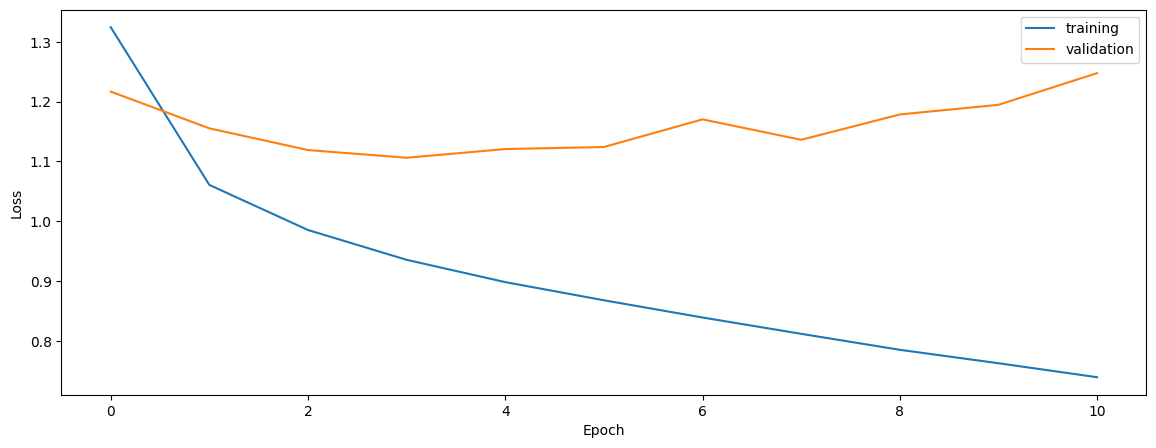

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6405416543551623
0.5670197212489695
0.6154129274256526


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.6161225673478266
0.5942240834386852
0.585652455302969


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.612390200648405
0.6019498984427895
0.5955736634079913


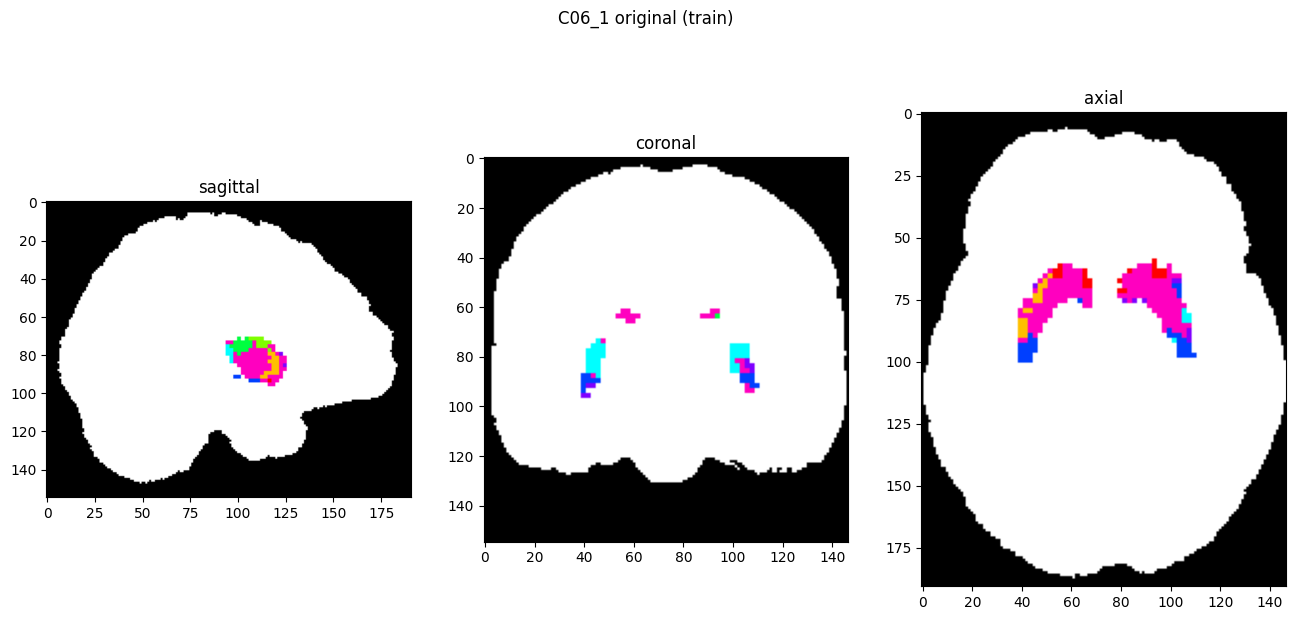

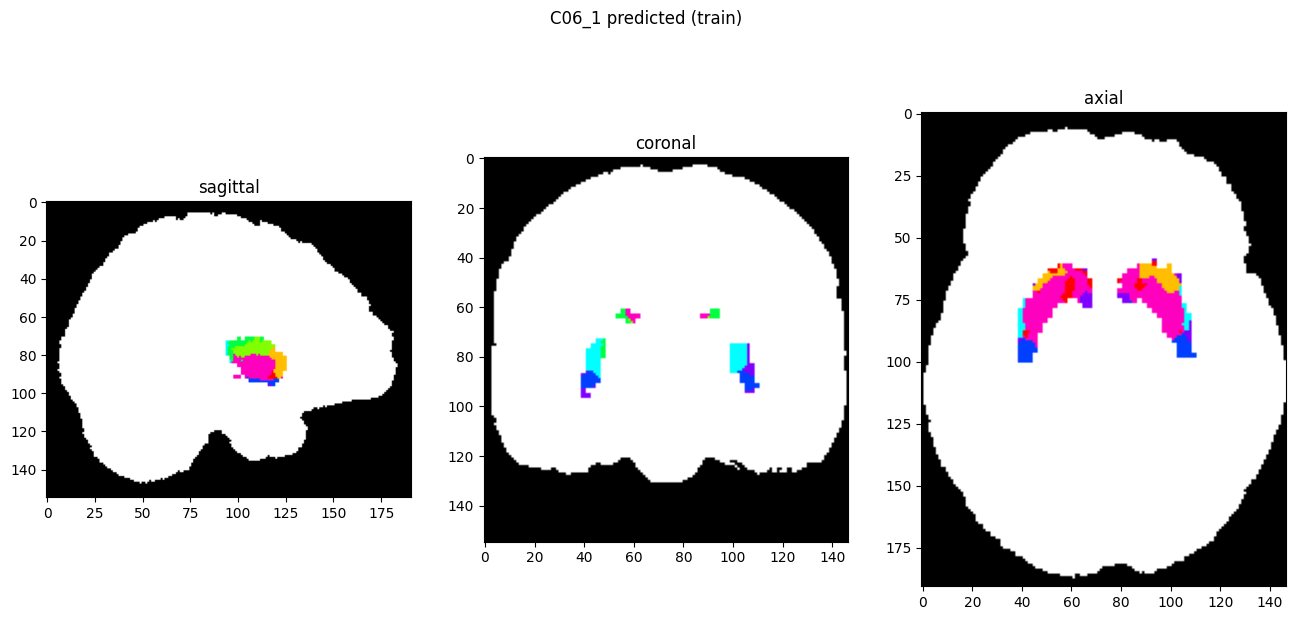

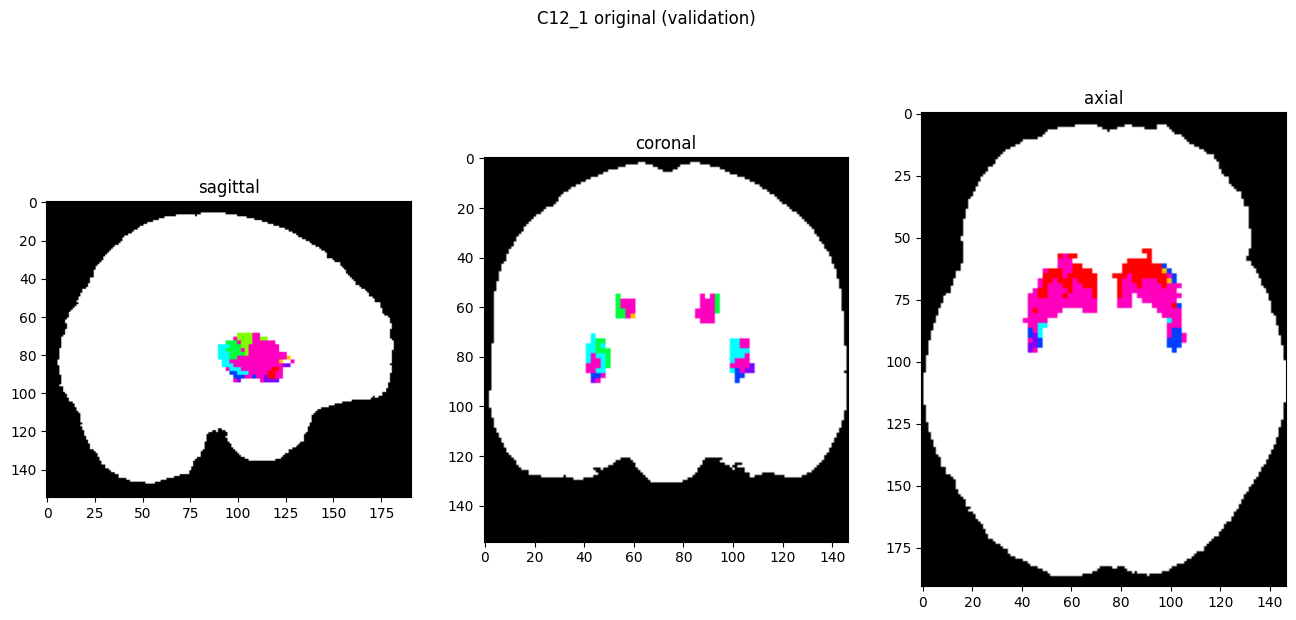

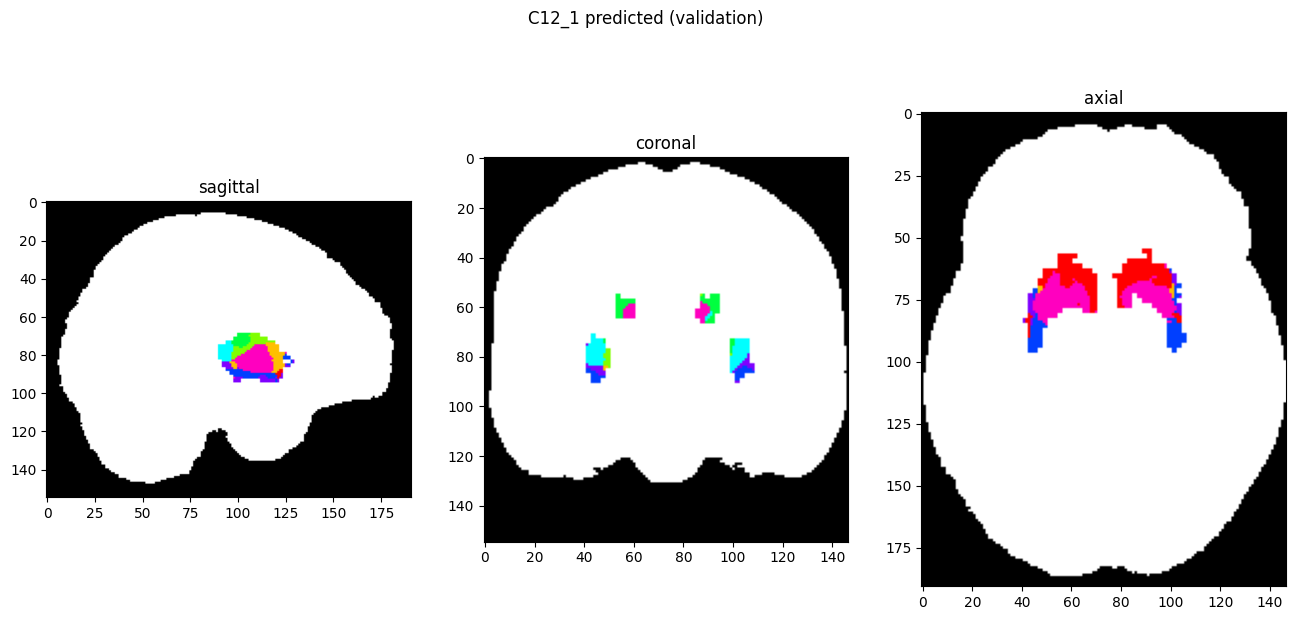

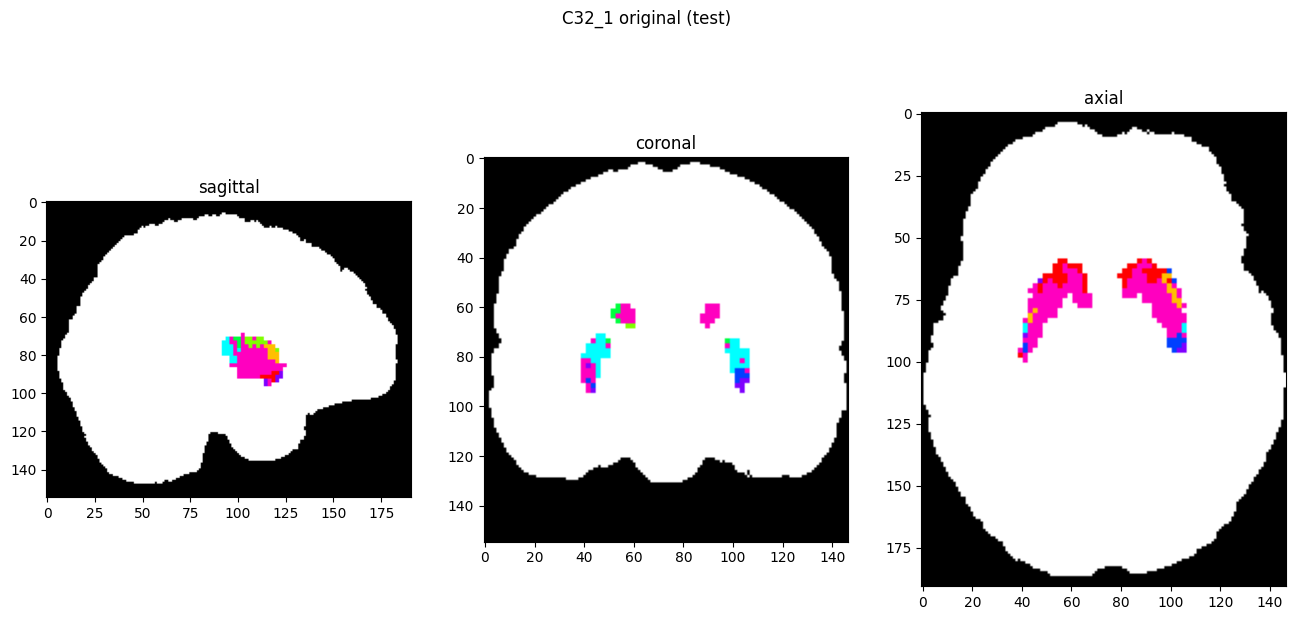

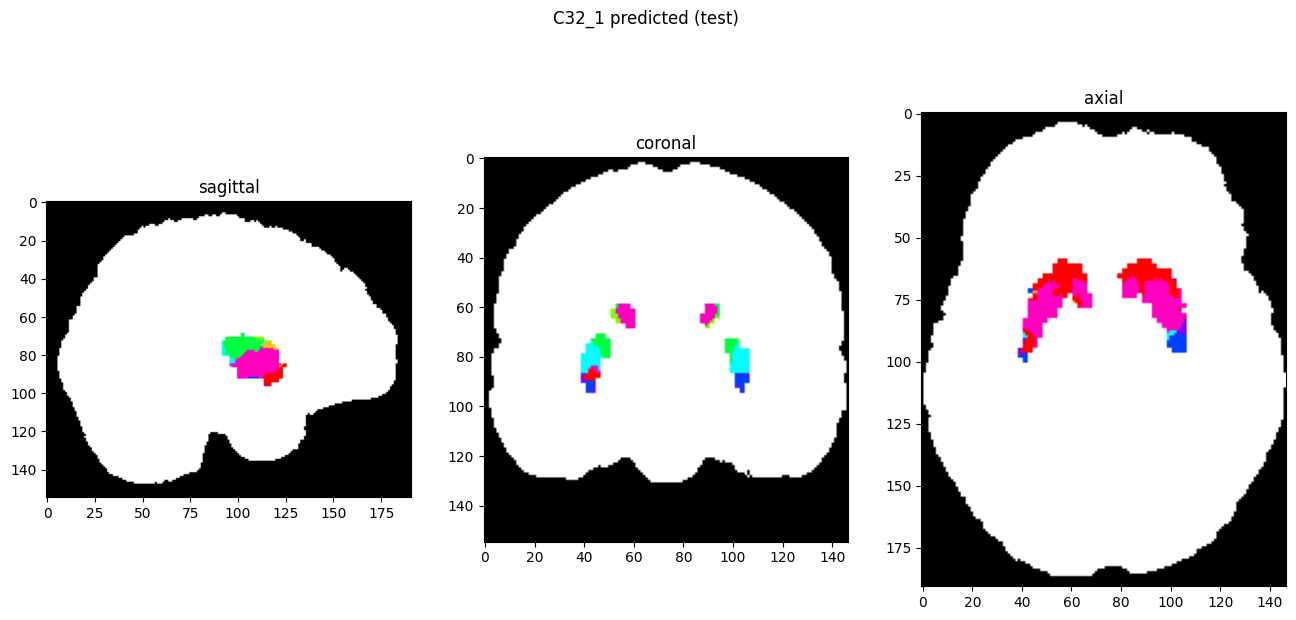

In [10]:
showResults(model, gen, threshold=0)